##  Full Specification Data Analysis

This is a comprehensive, structured examination of the dataset, where all variables (features) are documented, explored, and understood before modeling begins.

The analysis includes:
1. **Distributional analysis** of key variables
2. **Trend and seasonality decomposition** (additive & multiplicative)
3. **Stationarity checks**, including ADF test and rolling statistics
4. **Other diagnostics**, such as correlation heatmaps and ACF/PACF inspection

These insights will inform model selection and preprocessing strategies in the next phase.

### EDA Summary: Data-Driven Reasoning Behind Analysis & Modeling

#### 1. Dataset Summary

The dataset consists of high-frequency time series data from March 5 to May 12, 2025, with 19,799 rows and 67 variables. Each row captures the state of the Bitcoin mempool, network activity, and market conditions at a given point in time.

The target variable, `fastestFee`, estimates the minimum fee rate (in sat/vByte) required for a transaction to be included in the next block.

**Key observations:**

- `fastestFee` is heavily skewed with frequent spikes, reflecting volatile network congestion. This motivates the use of flexible, nonlinear models.
- Several features—especially histogram bins—exhibit extreme skewness or constant values. We removed uninformative variables and log-transformed long-tailed distributions.
- No major missing data issues were found.
- Features were grouped into four interpretable domains: **fee estimates**, **mempool state**, **block-level metrics**, and **market indicators**.

These findings informed our decisions for feature selection, transformation, and model type.

---

#### 2. Time Series-Specific EDA (Starting in Section 7)

##### Seasonal Decomposition

**Motivation:**  
To detect recurring patterns (daily or weekly) that may inform seasonal model components.

**Findings:**  
- Strong **daily seasonality** is observed after 15-minute resampling (96 intervals/day).
- Higher fees are common during active daytime hours, especially on weekdays.
- **Weekly patterns** were weak and inconsistent.

**Implication:**  
Models like **HWES** and **SARIMA** are well-suited to capture daily cycles. This also supports creating lag-based features aligned with daily behavior.

---

##### Stationarity Check

**Motivation:**  
To evaluate whether the target series has a stable mean and variance—required for models like ARIMA.

**Findings:**  
- Rolling mean and standard deviation show moderate stability.
- The **ADF test** confirms stationarity (p < 0.05).

**Implication:**  
Differencing is unnecessary. Stationarity supports using models like **SARIMA** directly and simplifies transformations for other methods.

---

##### ACF / PACF Analysis

**Motivation:**  
To assess the lag structure and memory of the target variable.

**Findings:**  
- ACF indicates high autocorrelation at lag 1 and lag 2.
- PACF sharply declines after lag 2, suggesting an **AR(2)**-like structure.

**Implication:**  
Supports setting `p = 2` for ARIMA-type models and including `lag_1`, `lag_2`, etc. as features in models like **XGBoost**.

---

##### Correlation Heatmaps

**Motivation:**  
To identify external variables that are predictive of `fastestFee`.

**Findings:**  
- Strong positive correlations with `mempool_total_fee`, `mempool_blocks_totalFees`, and `mempool_count`.
- Market features like `price_usd_diff_1h` show moderate correlation.

**Implication:**  
Multivariate models like **XGBoost** can leverage these features to capture congestion dynamics and nonlinear relationships.

---

#### 3. Modeling Rationale (Driven by EDA)

We selected three baseline models based directly on observed data characteristics:

- **SARIMA (Seasonal ARIMA):**  
  Chosen because the target is stationary and exhibits short-term autocorrelation. PACF supports AR(2)-like structure.

- **HWES (Holt-Winters Exponential Smoothing):**  
  Captures level, trend, and daily seasonality. Well-matched to smooth, cyclical patterns in `fastestFee`.

- **XGBoost:**  
  A nonlinear, multivariate model suited for incorporating lagged features and exogenous variables. Correlation heatmaps validate the value of these inputs.

These models were selected based on empirical analysis—not assumptions—ensuring alignment between model design and data properties.


### 1. Import Libraries & Load Dataset

We load the raw dataset containing Bitcoin mempool and blockchain metadata for downstream analysis.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [32]:
df = pd.read_parquet('../../data/raw/mar_5_may_12.parquet')

df.head()

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_550_600,mempool_fee_histogram_bin_600_650,mempool_fee_histogram_bin_650_700,mempool_fee_histogram_bin_700_750,mempool_fee_histogram_bin_750_800,mempool_fee_histogram_bin_800_850,mempool_fee_histogram_bin_850_900,mempool_fee_histogram_bin_900_950,mempool_fee_histogram_bin_950_1000,mempool_fee_histogram_bin_1000_plus
0,1741140733,2210077.0,997916.50,556.0,1615739.0,1.300082,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1741140881,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1741141182,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1741141481,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1741141782,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df.shape

(19799, 83)

### 2. Data Description
The dataset is comprised of Mar. 5 - Apr. 15, 2025 hourly time series data with 11902 rows × 67 columns (with primarily floating values). The dataset contains the following features:

![](../img/data_description.png)

### 3. Data Cleaning

To reduce dimensionality and remove irrelevant features, we dropped histogram bin columns whose values were all zero across the dataset. These columns do not provide any variance or predictive signal.

Next, we ensured that the `timestamp` column is properly converted and set as the DataFrame index. This enables correct alignment for downstream time series modeling.

In [34]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)
df = df.iloc[1:]
# df.to_parquet("../data/processed/cleaned.parquet")

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [35]:
df.shape

(19798, 67)

### 4. General Overview

#### 4.1 Dataset Summary

In [36]:
print(f"Dataset shape: {df.shape}")
df.info()
df.describe(include='all').T

Dataset shape: (19798, 67)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19798 entries, 2025-03-05 02:14:41 to 2025-05-12 19:59:41
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  19797 non-null  float64
 1   mempool_blocks_blockVSize                 19797 non-null  float64
 2   mempool_blocks_nTx                        19797 non-null  float64
 3   mempool_blocks_totalFees                  19797 non-null  float64
 4   mempool_blocks_medianFee                  19797 non-null  float64
 5   recommended_fee_fastestFee                19798 non-null  float64
 6   recommended_fee_halfHourFee               19798 non-null  float64
 7   recommended_fee_hourFee                   19798 non-null  float64
 8   recommended_fee_economyFee                19798 non-null  float64
 9   recommended_fee_minimumFee                1

,count,mean,std,min,25%,50%,75%,max
mempool_blocks_blockSize,19797.0,1.607857e+06,3.942101e+05,7501.00,1.515894e+06,1.629756e+06,1.746011e+06,3.914498e+06
mempool_blocks_blockVSize,19797.0,9.509390e+05,1.681826e+05,4367.25,9.979165e+05,9.979565e+05,9.979835e+05,9.979998e+05
mempool_blocks_nTx,19797.0,2.764964e+03,1.177938e+03,15.00,1.905000e+03,2.949000e+03,3.651000e+03,6.408000e+03
mempool_blocks_totalFees,19797.0,4.079149e+06,3.701828e+06,15658.00,2.116165e+06,3.212762e+06,4.890239e+06,8.107809e+07
mempool_blocks_medianFee,19797.0,2.817556e+00,4.733157e+00,0.00,1.288066e+00,2.047615e+00,3.154065e+00,2.731774e+02
...,...,...,...,...,...,...,...,...
mempool_fee_histogram_bin_95_100,19798.0,1.280973e+01,8.060690e+02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,5.217400e+04
mempool_fee_histogram_bin_100_150,19798.0,1.183400e+03,1.225070e+04,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.117370e+05
mempool_fee_histogram_bin_150_200,19798.0,2.226801e+02,3.703575e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,6.893900e+04
mempool_fee_histogram_bin_200_250,19798.0,7.076195e+01,2.137248e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,9.550100e+04


- All columns are of type float64 and contain no missing values.
- Many of the larger fee histogram bins contain a high proportion of zeros.
- We observed anomalies in the price_USD feature, where the minimum value is -1.
- We further investigate this issue before exploring the distribution of each feature.

#### 4.2 Anomaly Check

In [37]:
anomaly_prices = df[df['price_USD'] == -1]
anomaly_count = anomaly_prices.shape[0]
anomaly_timestamps = anomaly_prices.index 

print(f"Number of -1 values in 'price_USD': {anomaly_count}")
print(f"Timestamps (or indices) with -1 values: {anomaly_timestamps}")

Number of -1 values in 'price_USD': 4
Timestamps (or indices) with -1 values: DatetimeIndex(['2025-04-07 21:29:41', '2025-04-07 21:34:41',
               '2025-04-07 21:39:42', '2025-04-11 16:44:41'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


- Out of 19,798 rows, only 4 entries in the price_USD column have a value of -1.
- This likely indicates missing price data during those hours.
- Given the minimal impact, these rows can either be dropped or handled using simple imputation.

#### 4.3 FastestFee Time Series with Mean, Median, and 99th Percentile

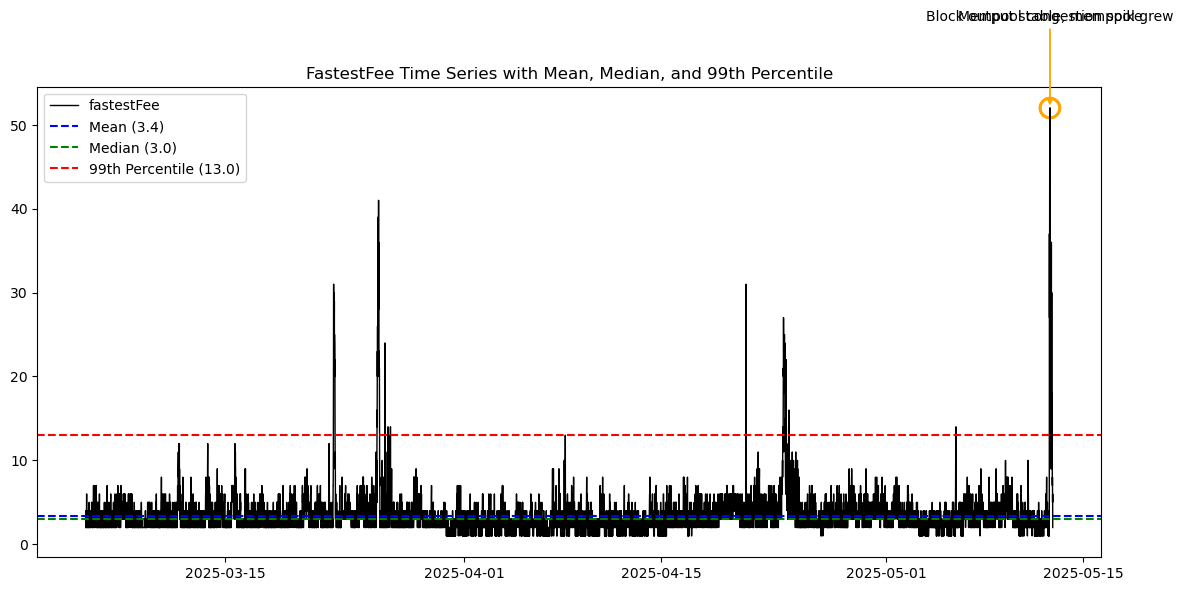

In [38]:
# 1. Extract the fastestFee series and drop any missing values
s = df['recommended_fee_fastestFee'].dropna()

# 2. Calculate summary statistics
mean_val   = s.mean()
median_val = s.median()
upper99    = s.quantile(0.99)

# 3. Identify the top 2 peak values and their timestamps
top2 = s.nlargest(2)
times = top2.index
vals  = top2.values

# 4. Create the plot
plt.figure(figsize=(12, 6))
plt.plot(s.index, s, color='black', linewidth=1, label='fastestFee')

# 5. Plot horizontal lines for mean, median, and 99th percentile
plt.axhline(mean_val,   color='blue',   linestyle='--', label=f'Mean ({mean_val:.1f})')
plt.axhline(median_val, color='green',  linestyle='--', label=f'Median ({median_val:.1f})')
plt.axhline(upper99,    color='red',    linestyle='--', label=f'99th Percentile ({upper99:.1f})')

# 6. Highlight the two highest peaks with hollow bubbles and annotate them
annotations = [
    'Block output stable, mempool grew',     # First bubble (higher spike, occurred later)
    'Mempool congestion spike'               # Second bubble (occurred earlier)
]

for (t, v), text in zip(zip(times, vals), annotations):
    plt.scatter(t, v, s=200, facecolors='none',
                edgecolors='orange', linewidths=2)
    plt.annotate(
        text,
        xy=(t, v), xytext=(t, v * 1.2),
        arrowprops=dict(arrowstyle='->', color='orange'),
        ha='center'
    )

# 7. Add title, legend, and layout
plt.title('FastestFee Time Series with Mean, Median, and 99th Percentile')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


**Insight:**  
We observed two extreme spikes in `fastestFee`. Upon investigation, both events coincided with rapid growth in mempool congestion, while block throughput remained stable.  
This suggests that the spikes were likely caused by temporary network overloads where demand outpaced supply.

### 5. Feature Description Distribution

#### 5.1 Summary Table of Key Features

| Feature                                  | Description                                            |
|:-----------------------------------------|:-------------------------------------------------------|
| mempool_blocks_blockSize                 | Total raw block size of pending transactions (bytes)   |
| mempool_blocks_blockVSize                | Virtual size of pending block (vBytes)                 |
| mempool_blocks_nTx                       | Number of transactions in the estimated next block     |
| mempool_blocks_totalFees                 | Total fees expected in next block (satoshis)           |
| mempool_blocks_medianFee                 | Median fee rate in the next block (sats/vB)            |
| recommended_fee_fastestFee               | Recommended fee for fastest confirmation (sats/vB)     |
| recommended_fee_halfHourFee              | Recommended fee for confirmation within 30 mins        |
| recommended_fee_hourFee                  | Recommended fee for confirmation within 1 hour         |
| recommended_fee_economyFee               | Recommended low-priority fee (slower confirmation)     |
| recommended_fee_minimumFee               | Minimum fee needed to enter the mempool                |
| mempool_count                            | Number of unconfirmed transactions in the mempool      |
| mempool_vsize                            | Total virtual size of mempool (vBytes)                 |
| mempool_total_fee                        | Total fee volume of mempool (sats)                     |
| difficulty_adjustment_progressPercent    | Progress toward next difficulty adjustment (%)         |
| difficulty_adjustment_difficultyChange   | Expected difficulty change (%)                         |
| difficulty_adjustment_remainingBlocks    | Blocks left until next difficulty adjustment           |
| difficulty_adjustment_remainingTime      | Estimated time until difficulty adjustment (sec)       |
| difficulty_adjustment_previousTime       | Time taken for the previous difficulty epoch (sec)     |
| difficulty_adjustment_nextRetargetHeight | Height at which next difficulty retarget occurs        |
| difficulty_adjustment_timeAvg            | Average time between blocks in the current epoch (sec) |
| difficulty_adjustment_adjustedTimeAvg    | Adjusted average block time considering skew           |
| difficulty_adjustment_timeOffset         | Time offset vs. expected block production              |
| difficulty_adjustment_expectedBlocks     | Expected blocks per difficulty period                  |
| price_USD                                | Bitcoin market price in USD                            |
| price_EUR                                | Bitcoin market price in EUR                            |
| price_GBP                                | Bitcoin market price in GBP                            |
| price_CAD                                | Bitcoin market price in CAD                            |
| price_CHF                                | Bitcoin market price in CHF                            |
| price_AUD                                | Bitcoin market price in AUD                            |
| price_JPY                                | Bitcoin market price in JPY                            |
| mempool_fee_histogram_bin_               | Each mempool_fee_histogram_bin_* feature represents the number of transactions in the mempool whose fee rate falls within a specific sats/vB range (e.g., bin_1_2 means 1–2 sats/vB).|

#### 5.2 Mempool Block Features

The mempool block features exhibit varying levels of skewness. For example, `mempool_blocks_totalFees` and `mempool_blocks_medianFee` show strong right-skewed distributions, suggesting high variability in fee values. These may benefit from log transformation in modeling.


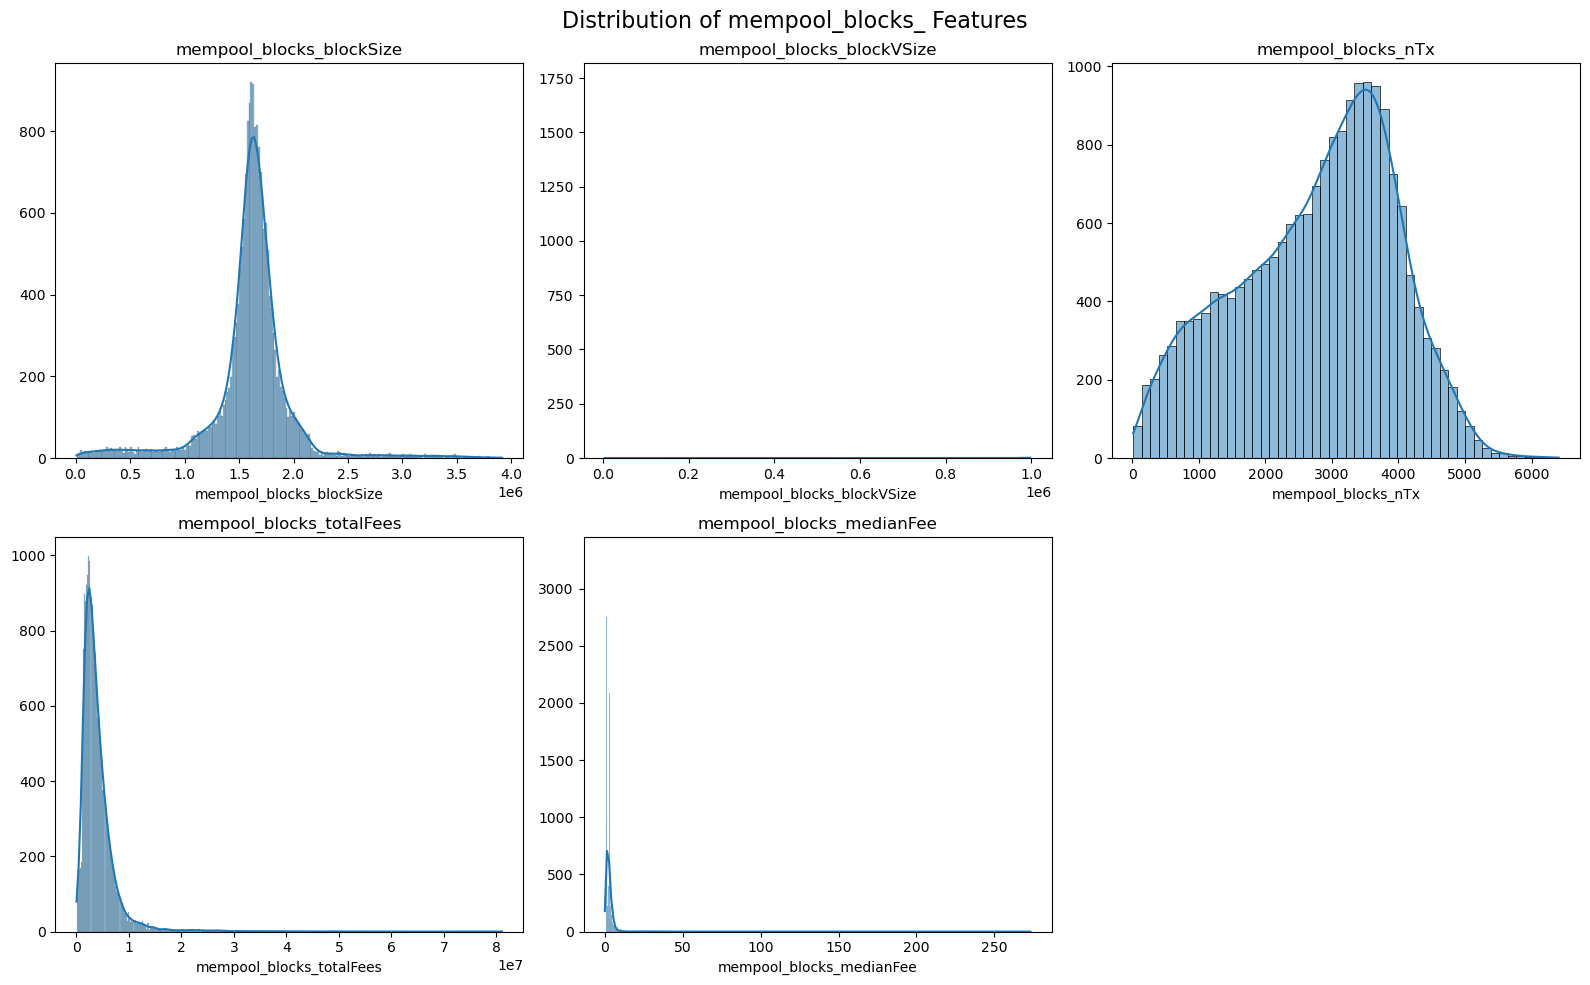

In [39]:
def plot_feature_group(df, prefix, max_cols=3, figsize=(16, 10)):
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    n = len(group_cols)
    rows = (n + max_cols - 1) // max_cols
    fig, axes = plt.subplots(rows, max_cols, figsize=figsize, squeeze=False)
    
    for i, col in enumerate(group_cols):
        ax = axes[i // max_cols][i % max_cols]
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(col)
        ax.set_ylabel("")
    for j in range(i+1, rows * max_cols):
        fig.delaxes(axes[j // max_cols][j % max_cols])

    fig.suptitle(f"Distribution of {prefix} Features", fontsize=16)
    fig.tight_layout()
    plt.show()

plot_feature_group(df, "mempool_blocks_")


#### 5.3 Mempool State Features

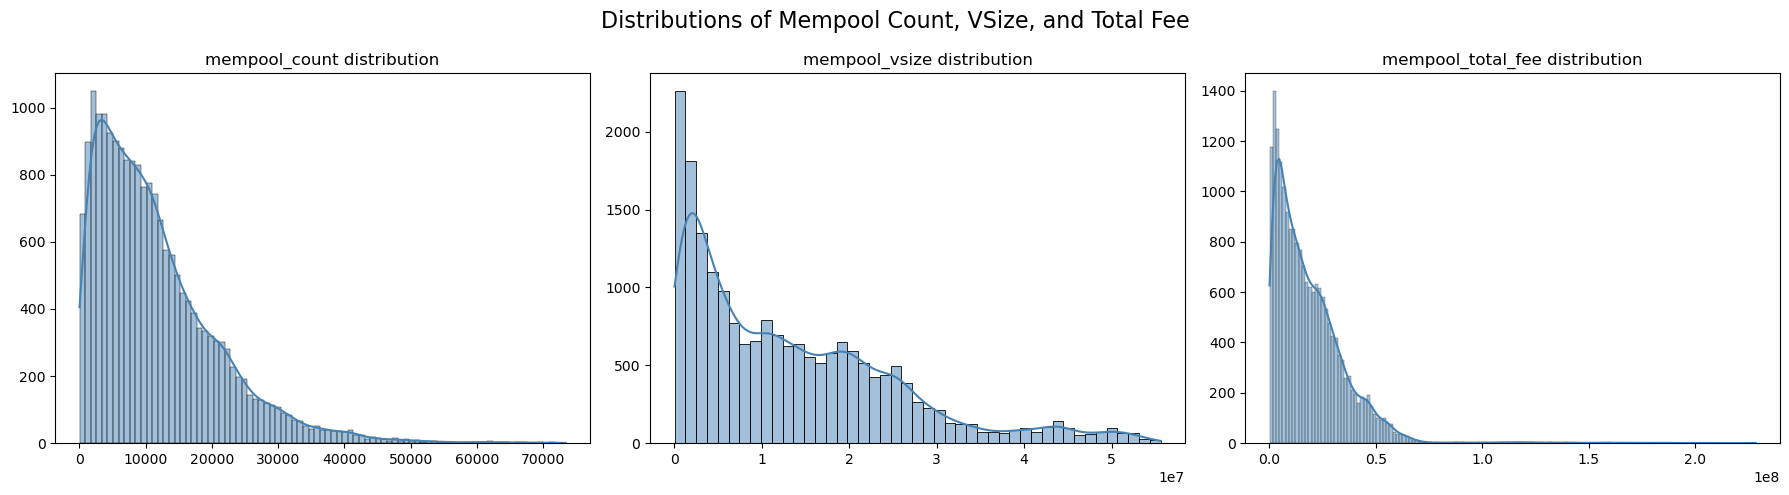

In [40]:
features = ["mempool_count", "mempool_vsize", "mempool_total_fee"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")

fig.suptitle("Distributions of Mempool Count, VSize, and Total Fee", fontsize=16)
plt.tight_layout()
plt.show()

- `mempool_count`, `mempool_vsize` and `mempool_total_fee` all exhibit strong right-skewness with long tails.

- A log transformation or outlier trimming may help stabilize variance and improve model fit.


#### 5.4 Difficulty Adjustment Features

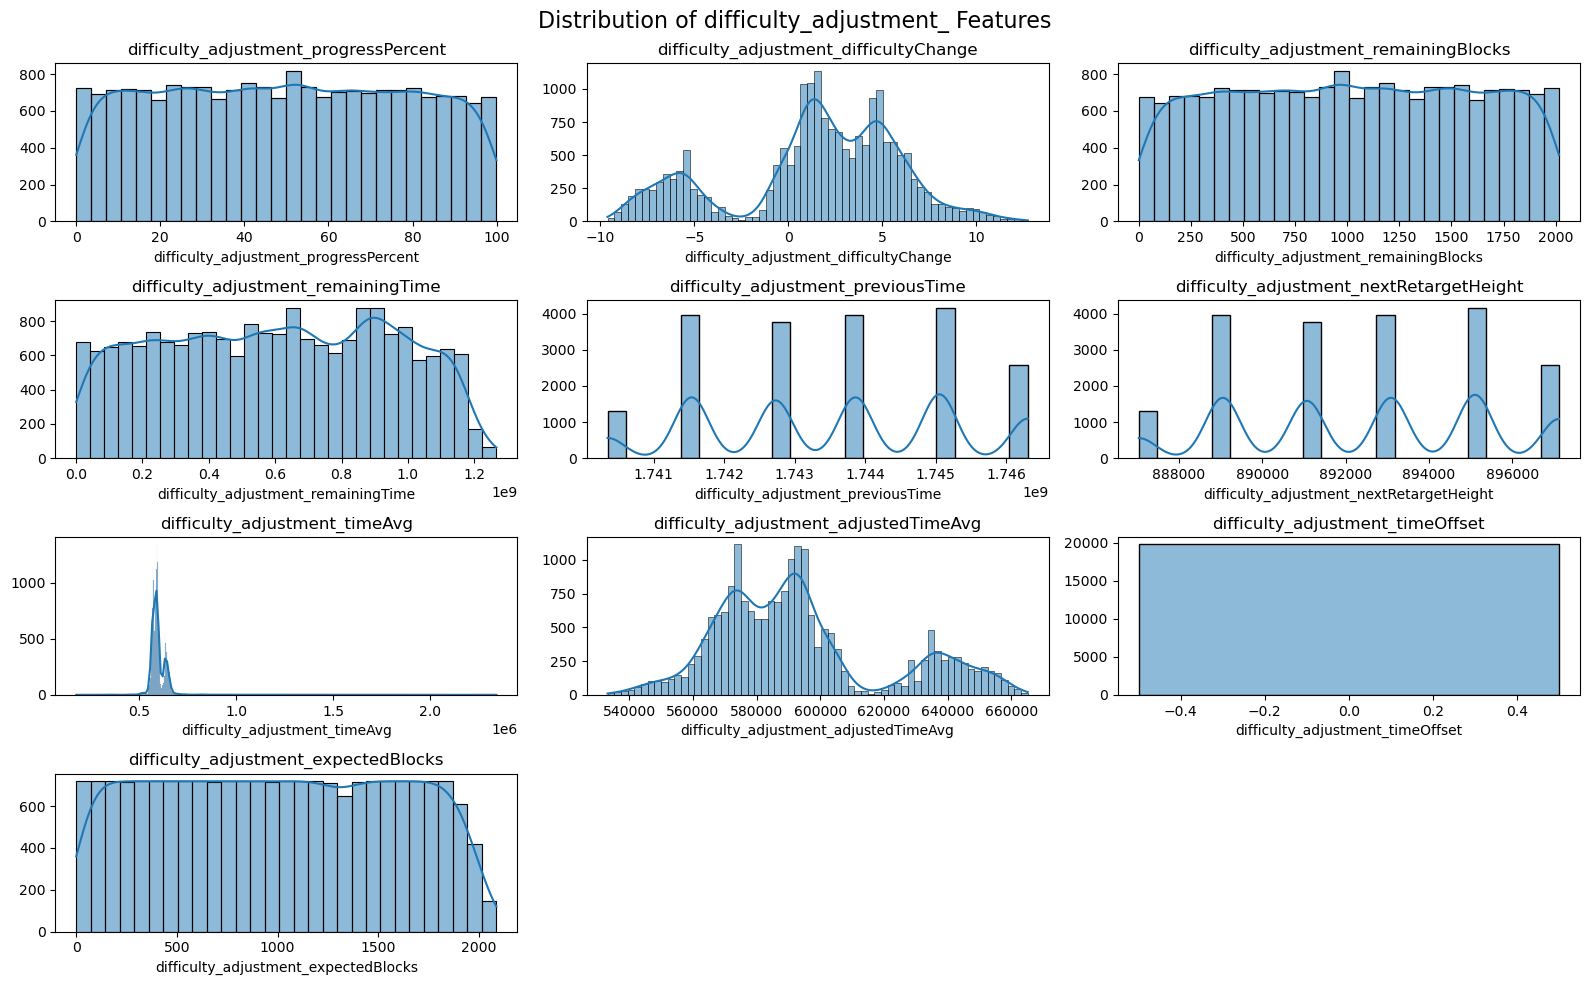

In [41]:
plot_feature_group(df, "difficulty_adjustment_")


- Features like `difficulty_adjustment_progressPercent` and `difficulty_adjustment_expectedBlocks` appear roughly uniform or multi-modal, reflecting variability across epochs.

- Discrete spikes in `previousTime` and `nextRetargetHeight` correspond to deterministic retarget boundaries—these may serve as useful epoch markers.

#### 5.5 Price Features

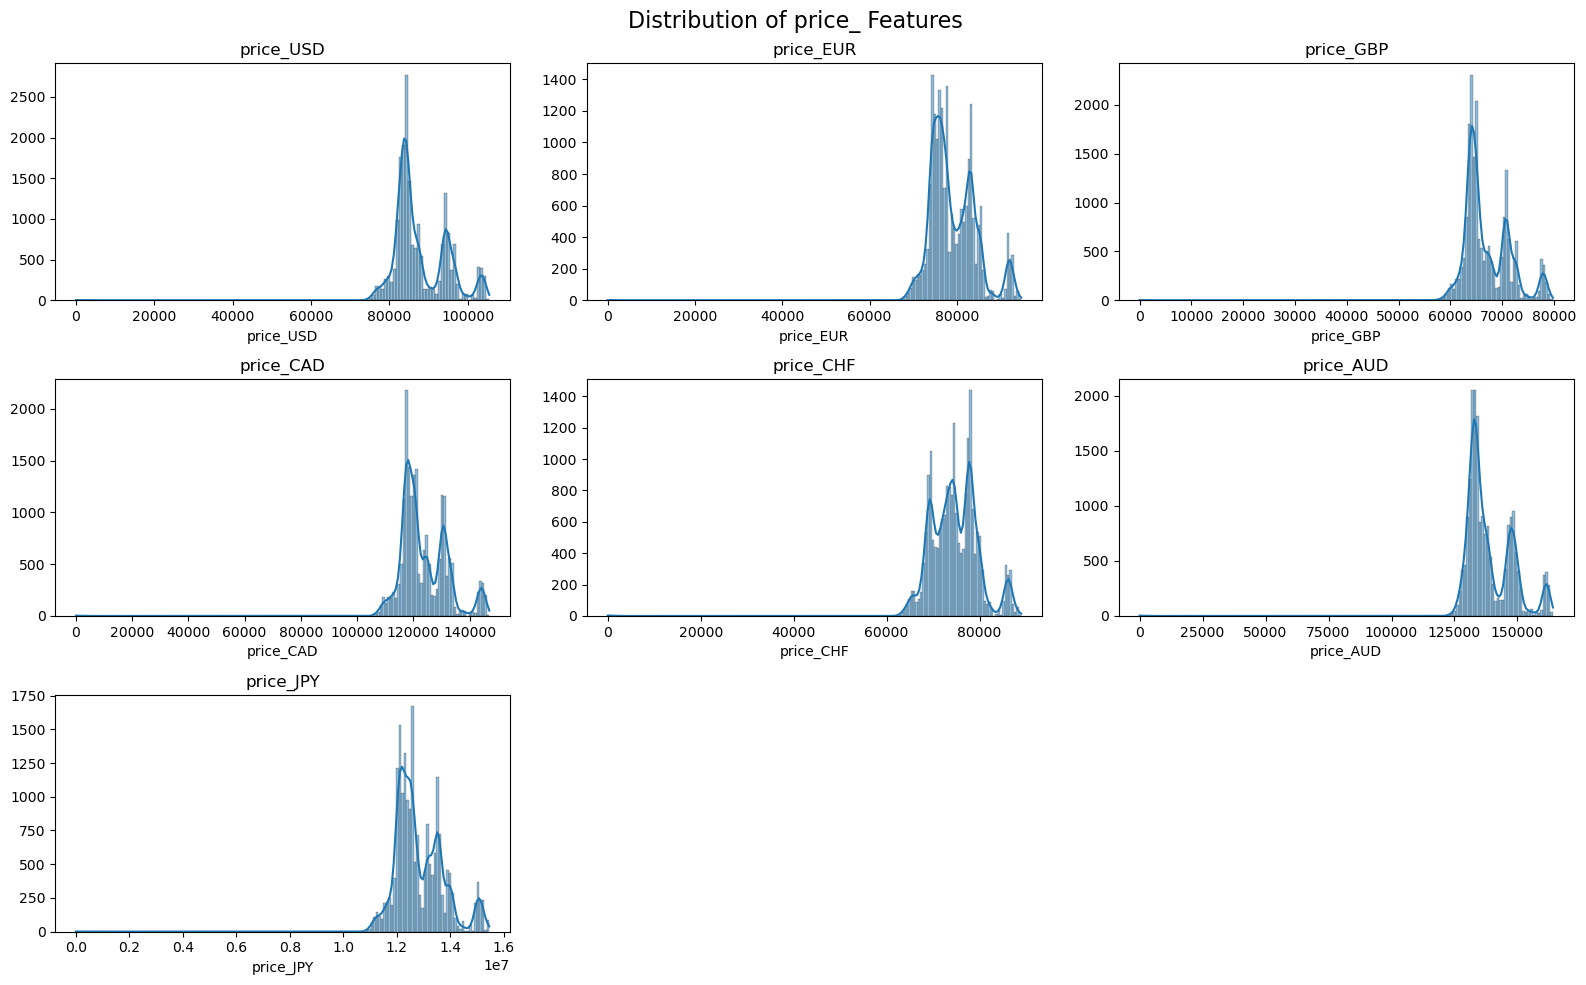

In [42]:
plot_feature_group(df, "price_")

- All currency prices (`price_USD`, `price_EUR`, …) cluster around narrow ranges with similar shapes, apart from four outlier points at –1 (handled earlier).

- Price series are relatively stable and can be treated as external covariates without additional transformation.

#### 5.6 Histogram Bin Features

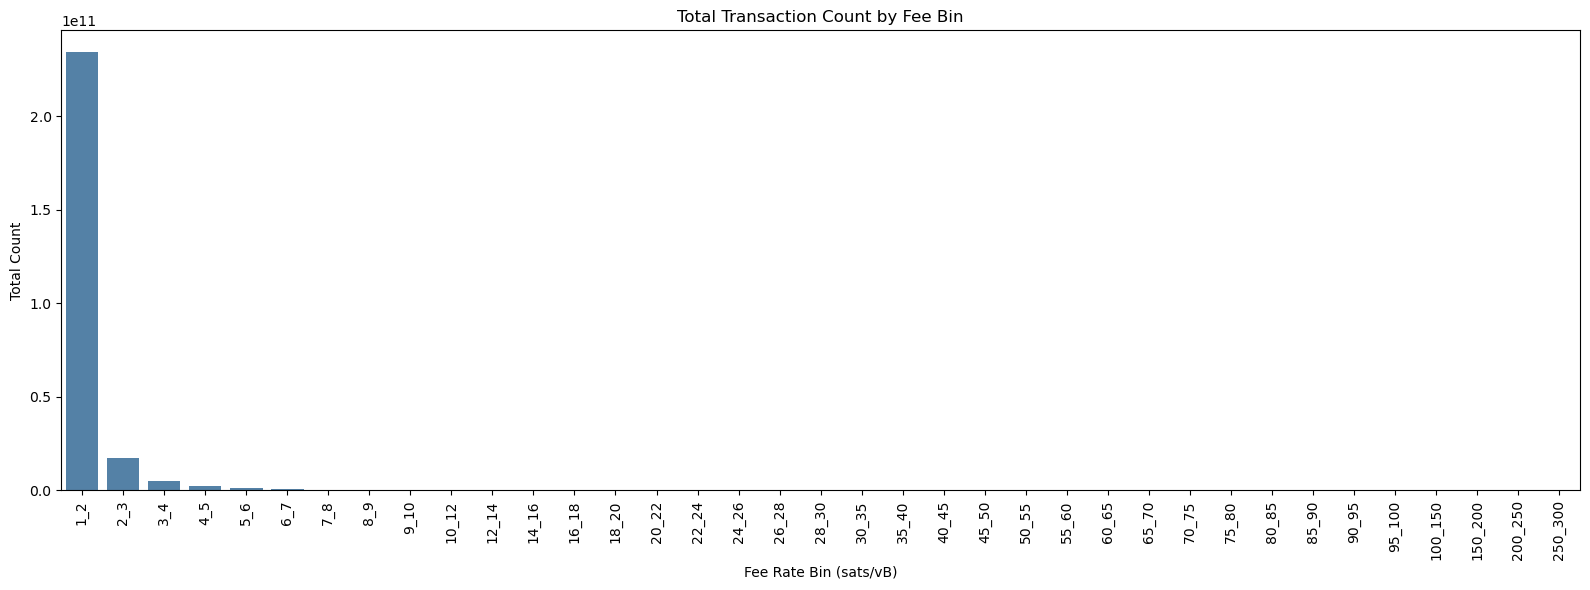

In [43]:
fee_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()
def extract_start(bin_name):
    return float(bin_name.split("_")[-2])
total_per_bin = total_per_bin.sort_values(key=lambda x: [extract_start(c) for c in x.index])
bin_labels = [col.replace("mempool_fee_histogram_bin_", "") for col in total_per_bin.index]
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=total_per_bin.values, color="steelblue")
plt.xticks(rotation=90)
plt.title("Total Transaction Count by Fee Bin")
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()


- Roughly 92.5% of all transactions fall into the 1–2 sats/vB bin; including 2–3 sats/vB brings the cumulative share above 96%.

- Higher-fee bins are extremely sparse—consider merging rare bins or focusing only on the first few for modeling to reduce sparsity.

#### 5.7 Fee Bin Proportions

In [44]:
# Calculate the proportion of each bin's count relative to the total count
total_count = total_per_bin.sum()
bin_proportions = total_per_bin / total_count * 100
bin_proportions.head()

mempool_fee_histogram_bin_1_2    88.918346
mempool_fee_histogram_bin_2_3     6.608440
mempool_fee_histogram_bin_3_4     1.889749
mempool_fee_histogram_bin_4_5     0.970637
mempool_fee_histogram_bin_5_6     0.553460
dtype: float64

- Over **98%** of all transactions fall into the **0–5 sats/vB** range  
  (**88.9%** in 1–2, **6.6%** in 2–3, **1.9%** in 3–4, **1.0%** in 4–5 sats/vB)

- Bins above 5 sats/vB are extremely rare (**0.6%**) and could be aggregated or treated as “other” in downstream modeling to reduce sparsity.

#### 5.8 Log-Scaled Fee Bin Counts

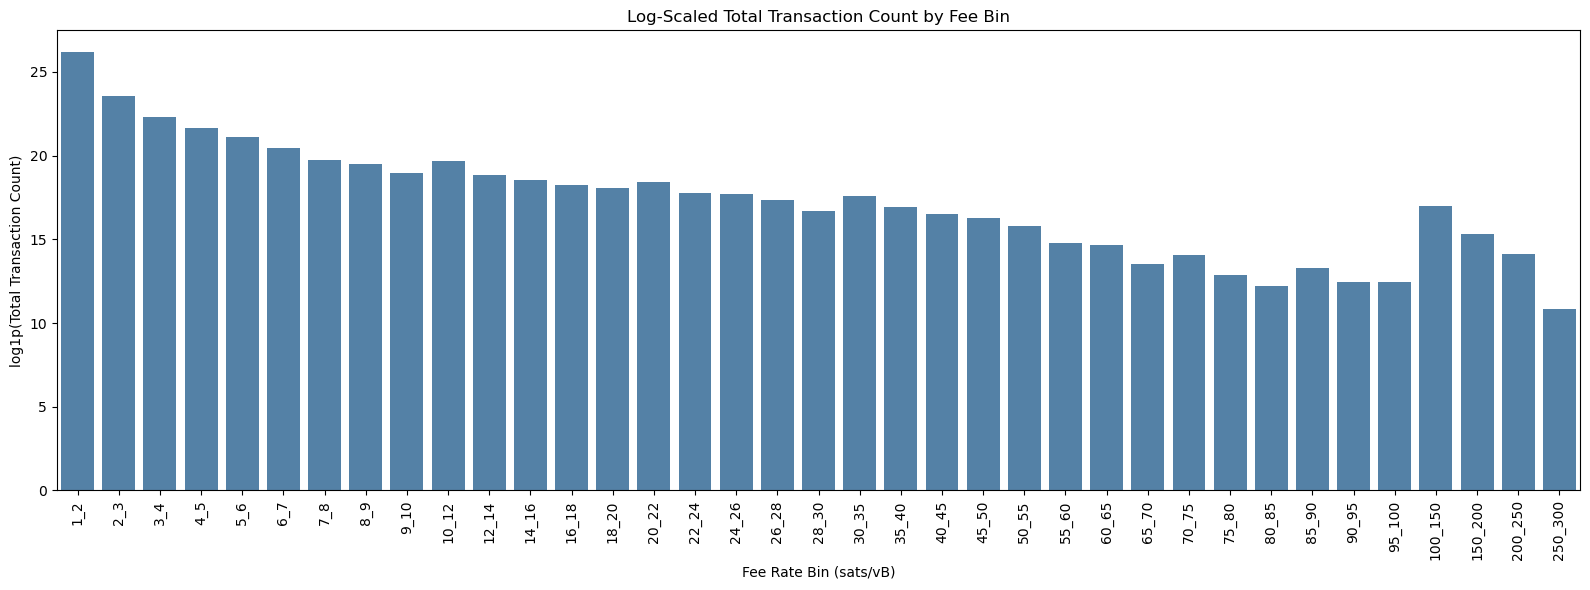

In [45]:
# Sum total transaction counts for each fee bin
fee_cols = [c for c in df.columns if c.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()

# Extract numeric labels for plotting
bin_labels = [c.replace("mempool_fee_histogram_bin_", "") for c in total_per_bin.index]

# Apply log1p transformation to counts
log_counts = np.log1p(total_per_bin)

# Plot the log-scaled counts
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=log_counts.values, color="steelblue")
plt.xticks(rotation=90)
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("log1p(Total Transaction Count)")
plt.title("Log-Scaled Total Transaction Count by Fee Bin")
plt.tight_layout()
plt.show()

After applying the log₁p transform, the dominance of the 1–2 sats/vB bin is still clear, but the decline across higher bins appears much smoother. This view highlights that, although the vast majority of transactions occur at very low fees, there is meaningful activity extending up to around 20 sats/vB rather than an immediate drop to near zero.


### 6. Timestamp Coverage & Sampling

We check the overall time coverage and sampling interval of the dataset.

In [46]:
print("Start:", df.index.min())
print("End:", df.index.max())
print("Frequency mode:", df.index.to_series().diff().mode())

Start: 2025-03-05 02:14:41
End: 2025-05-12 19:59:41
Frequency mode: 0   0 days 00:05:00
Name: timestamp, dtype: timedelta64[ns]


The most frequent sampling interval is 5 minutes, but the data is not strictly regular. Many forecasting models assume evenly spaced time steps, so we may need to reindex and interpolate the data later depending on the model's required frequency. (e.g., ARIMA, TFT, DeepAR)

### 7. Trend and Seaonality of Fastest Fee

We explore the temporal structure of the target variable `recommended_fee_fastestFee` to identify possible long-term trends and short-term seasonality patterns.

To match the model input format, we use a 5-minute resampled time series, with daily periodicity (`period=288`).

#### 7.1 Additive Decomposition of Target Feature

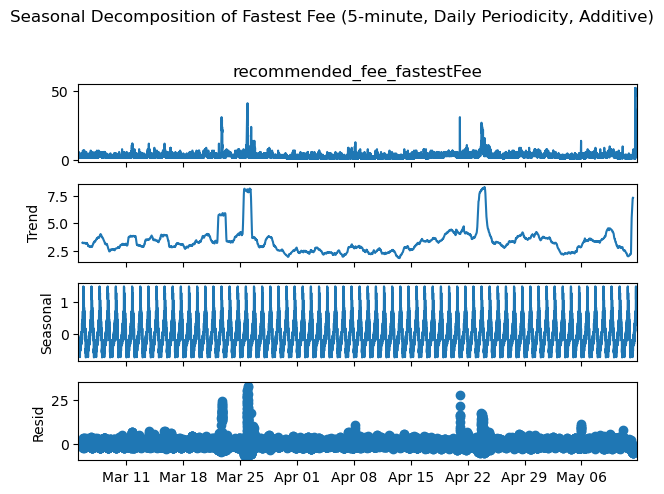

In [47]:
# Use 5-minute resampled data
# period=288 means 288 5-minute intervals = 1 day
decomp_result = seasonal_decompose(df["recommended_fee_fastestFee"], model='additive', period=288)
decomp_result.plot()
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) 
plt.suptitle("Seasonal Decomposition of Fastest Fee (5-minute, Daily Periodicity, Additive)", y=1.02)
plt.tight_layout()
plt.show()

We performed an additive decomposition on `recommended_fee_fastestFee` using a daily period (288 five-minute intervals).

- The trend component shows a gradual increase and a few prominent spikes, suggesting changing network demand over time.

- The seasonal component reveals a strong daily pattern, confirming periodicity in fee behavior.

- The residual component captures sharp local fluctuations and anomalies, particularly around March 22–25 and early April.

This result confirms that the fee rate exhibits clear trend and seasonality, and that decomposition can help isolate noise or unusual events for better forecasting.

#### 7.2 Multiplicative Decomposition of Target Feature

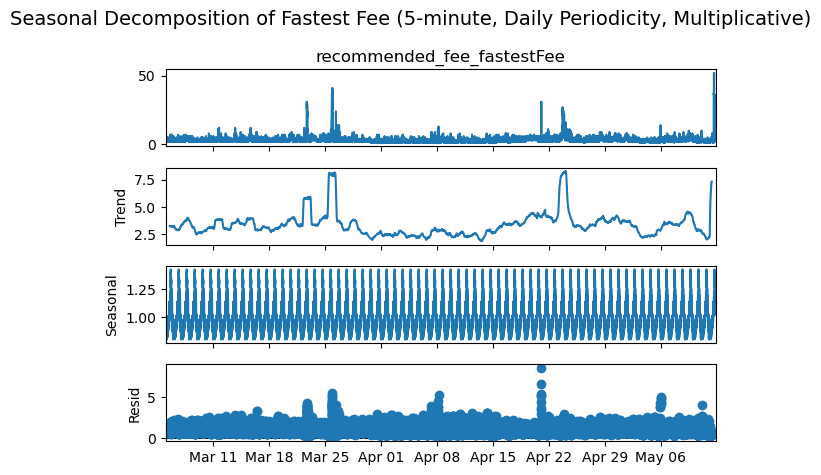

In [48]:
# Multiplicative decomposition using daily periodicity (288 intervals = 24 hours)
result_mul = seasonal_decompose(
    df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288
)

# Plot the decomposition
result_mul.plot()
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) 
plt.suptitle("Seasonal Decomposition of Fastest Fee (5-minute, Daily Periodicity, Multiplicative)", fontsize=14)
plt.tight_layout()
plt.show()

The multiplicative decomposition of `recommended_fee_fastestFee` reveals:

- A daily seasonality pattern with stable oscillations, confirming 24-hour trading cycles.
- A nonlinear trend showing a temporary fee spike in late March.
- Significant residual spikes suggest anomalous behavior or sudden congestion events not captured by seasonal or trend components.

This supports the use of time series models that account for both seasonality and event-driven outliers (e.g., Prophet, DeepAR).

#### 7.3 Residual Diagnostics

We examine whether the residual component from the multiplicative decomposition contains meaningful structure or is merely random noise.

We focus on the multiplicative version because it better captures the proportional seasonal variation observed in the original data.  
Additive residuals are not analyzed further, as multiplicative decomposition is more appropriate for our data scale and volatility patterns.

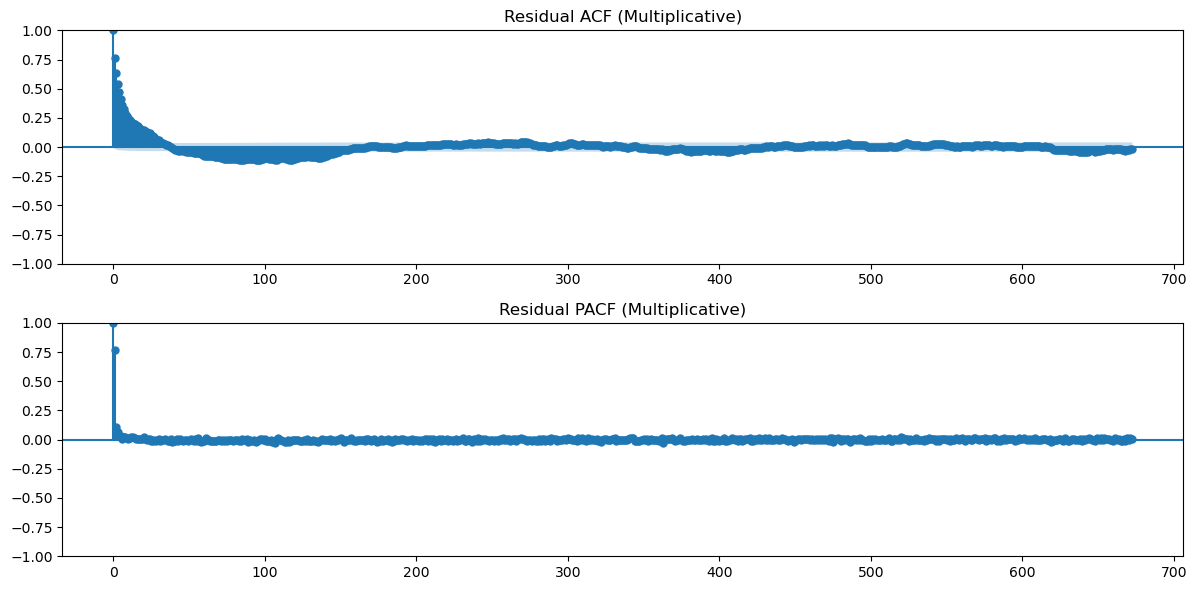

In [49]:
residuals = result_mul.resid.dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(residuals, ax=ax[0], lags=672, title='Residual ACF (Multiplicative)')
plot_pacf(residuals, ax=ax[1], lags=672, title='Residual PACF (Multiplicative)')
plt.tight_layout()
plt.show()

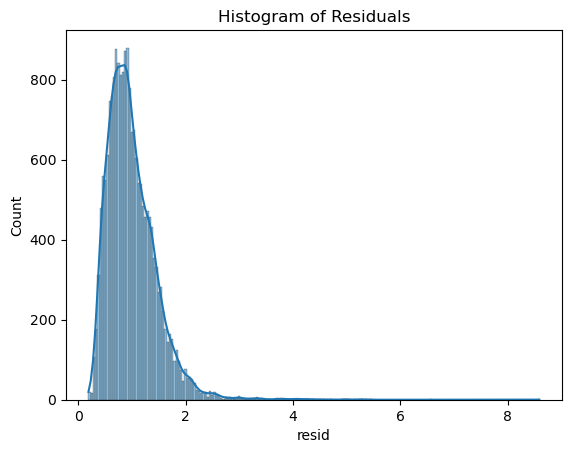

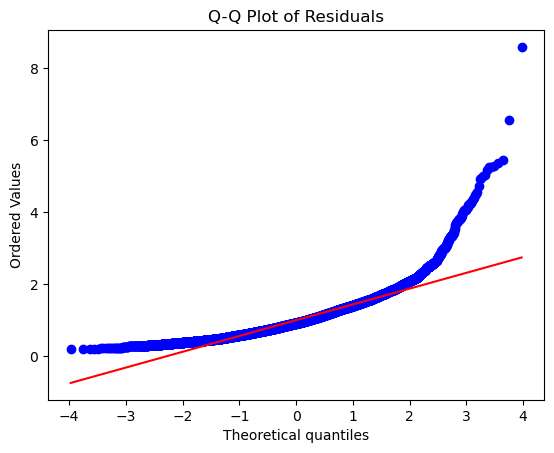

In [50]:
# Histogram
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

- **ACF and PACF plots** hows a slow decay rather than an immediate drop, indicating that the residual component still contains short-term autocorrelation.
- **Histogram and Q-Q plot** show that the residuals are right-skewed and deviate from a normal distribution, especially in the tails.

These findings suggest that the residuals are not purely white noise, and may still contain useful signal.  
Therefore, further investigation—such as segmenting residuals by date or incorporating them into a hybrid modeling approach—may be warranted.

In [51]:
# Extract residuals from multiplicative decomposition
residuals = result_mul.resid.dropna().to_frame(name='resid')

# Create custom week index from timestamp
start_time = residuals.index.min()
residuals['week'] = ((residuals.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Calculate summary stats per week
resid_stats = residuals.groupby('week')['resid'].describe()[['mean', 'std', 'min', 'max']]
display(resid_stats)


,mean,std,min,max
week,,,,
1,1.004249,0.390378,0.446884,2.650531
2,0.988730,0.382693,0.429432,3.331140
3,0.985712,0.644304,0.187176,5.443981
4,1.001817,0.437904,0.322742,2.953958
5,0.987337,0.536003,0.274949,5.255659
6,0.998457,0.491815,0.303353,3.095364
7,0.990312,0.453113,0.295467,8.589596
8,1.013908,0.409304,0.357552,2.922803
9,1.006077,0.442597,0.284087,4.953548


We analyze the weekly distribution of residuals from the multiplicative decomposition to identify whether specific time periods exhibit greater volatility or unexplained variation.

**Week 3** exhibits the highest overall residual variability, with both the largest standard deviation (0.64) and a local maximum residual value of 5.44.  
This suggests the presence of potential modeling underfit or unmodeled dynamics during that period.

**Week 5** also shows elevated residual dispersion (std = 0.54) and several high residuals (max = 5.26), though its variability is slightly less than Week 3.

In addition, **Week 7** presents the most extreme single outlier, with a maximum residual value of 8.59.  
While its overall standard deviation (0.45) is lower than Week 3 and 5, this sharp spike may reflect an isolated modeling failure or event-driven anomaly.

Overall, these findings suggest that residual volatility is not evenly distributed across weeks and may be driven by structural modeling gaps or real-world volatility bursts.


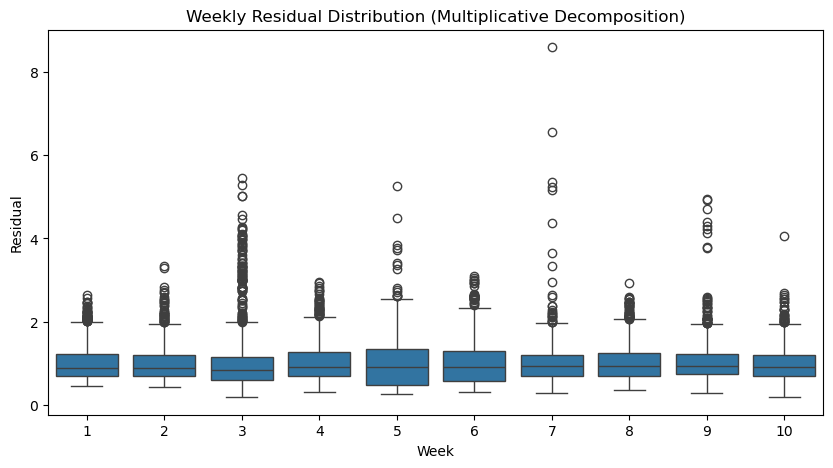

In [52]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=residuals, x='week', y='resid')
plt.title('Weekly Residual Distribution (Multiplicative Decomposition)')
plt.ylabel('Residual')
plt.xlabel('Week')
plt.show()

The boxplot confirms that **Week 3** exhibits the most extreme residual behavior, characterized by a wide interquartile range and a high density of upper outliers.  
This aligns with our earlier summary showing that Week 3 has the highest residual standard deviation and a local residual maximum of 5.44.

**Week 5** also demonstrates elevated residual dispersion and outlier presence, supporting the notion of recurring model underfit or external volatility during that week.

Additionally, **Week 7** presents an isolated extreme outlier (residual > 8.5), suggesting either an unmodeled event or a singular structural misspecification that warrants closer inspection.

These residual anomalies indicate non-uniform variance across time, reinforcing the need to investigate temporal effects or refine model assumptions for improved generalization.


#### 7.4 Weekly Seasonality Decomposition

To further explore longer-term cyclic behavior, we decomposed the fastest fee series using a 7-day seasonal period (2016 intervals based on 5-minute sampling). This allows us to inspect whether weekly patterns—such as weekday vs. weekend congestion—are present in the data.

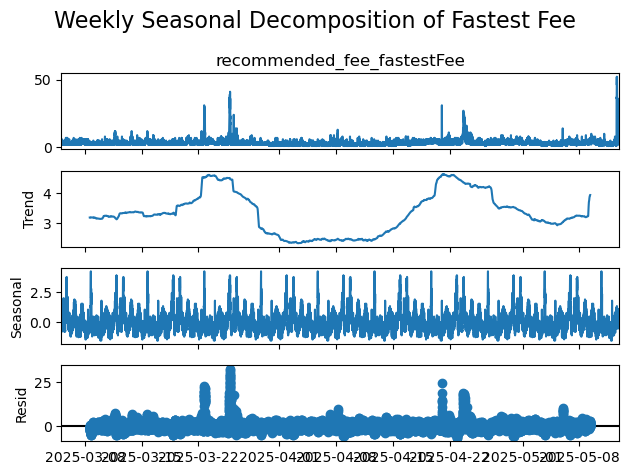

In [53]:
# Weekly decomposition (7 days = 2016 intervals for 5-minute data)
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_result = seasonal_decompose(df['recommended_fee_fastestFee'], model='additive', period=2016)
weekly_result.plot()
plt.suptitle("Weekly Seasonal Decomposition of Fastest Fee", fontsize=16)
plt.tight_layout()
plt.show()

The trend component shows alternating rise and fall segments across the study period, reflecting medium-term shifts in average transaction fee levels.

The seasonal component contains repeated local fluctuations, but does not exhibit a consistently strong weekly pattern. The spikes appear irregular and noisy, suggesting only weak or unstable weekly seasonality.

Residuals remain volatile, with multiple sharp spikes—especially in the middle weeks—indicating periods of unusual behavior or modeling gaps.

Overall, while some weekly patterns may be present, they are overshadowed by noise and residual volatility, limiting the strength of weekly seasonality in the data.


### 8. Stationarity Checks of Target Feature

We examine whether the target time series is stationary using visual and statistical methods. Stationarity is a key assumption for many time series models such as ARIMA.

#### 8.1 Rolling Mean and Standard Deviation

We plot the rolling mean and standard deviation of the target feature to visually assess stationarity. A stationary series should have relatively constant mean and variance over time.

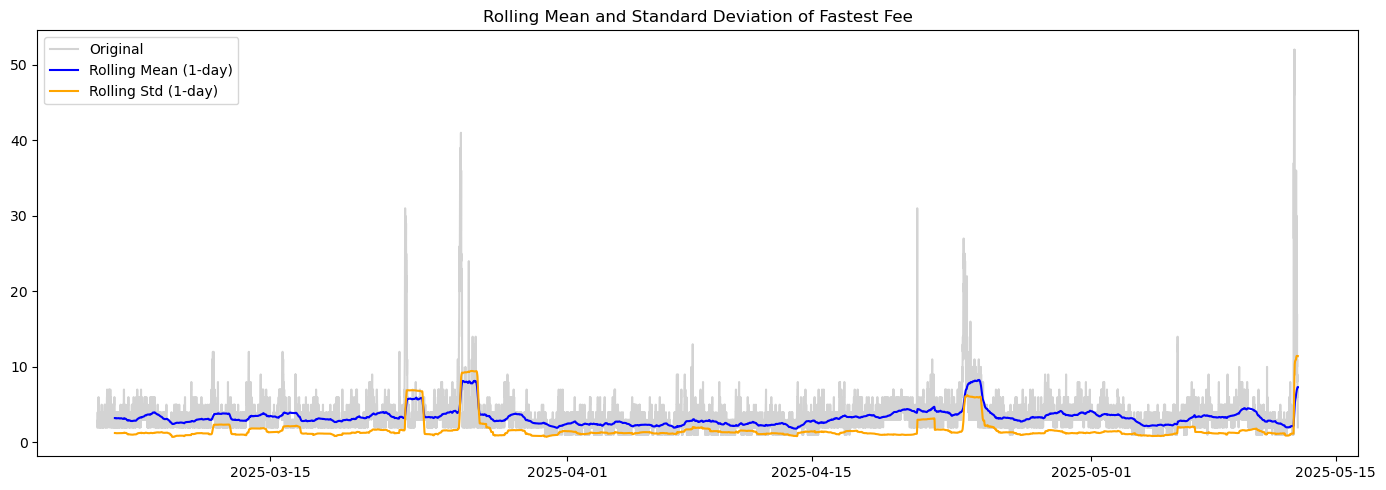

In [54]:
window = 288  # 1-day window for 5-min data

rolling_mean = df["recommended_fee_fastestFee"].rolling(window=window).mean()
rolling_std = df["recommended_fee_fastestFee"].rolling(window=window).std()

plt.figure(figsize=(14, 5))
plt.plot(df["recommended_fee_fastestFee"], color="lightgray", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean (1-day)")
plt.plot(rolling_std, color="orange", label="Rolling Std (1-day)")
plt.title("Rolling Mean and Standard Deviation of Fastest Fee")
plt.legend()
plt.tight_layout()
plt.show()

The plot shows:

- The rolling mean (blue) and rolling standard deviation (orange) both exhibit meaningful variation over time, indicating the series is not strictly stationary.

- Two distinct periods of increased volatility are visible:
  - The first occurs around **March 22–25**, where both rolling mean and std rise sharply, suggesting a short-term spike in fees.
  - The second occurs in **early May**, marked by a similar surge in both metrics and several sharp fee spikes in the raw series.

These shifts suggest non-stationarity in both the mean and variance of the series, highlighting the importance of transformations or modeling strategies that account for local trends and heteroskedasticity.


#### 8.2 Augmented Dickey-Fuller (ADF) Test

We perform the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the `recommended_fee_fastestFee` series. Understanding whether the series is stationary helps inform the choice of appropriate modeling techniques in subsequent steps.


In [55]:
# Perform ADF test on the target feature
adf_result = adfuller(df["recommended_fee_fastestFee"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -14.959102814626977
p-value: 1.2472595479998906e-27
Critical Value (1%): -3.4307
Critical Value (5%): -2.8617
Critical Value (10%): -2.5668


The ADF test result shows a test statistic of **-14.96**, which is significantly lower than all critical values at the 1%, 5%, and 10% levels.  
The p-value is effectively zero (**1.25e-27**), providing strong evidence to reject the null hypothesis of non-stationarity.

This suggests that the `recommended_fee_fastestFee` series is statistically stationary when assessed over the entire period.

However, as observed in the rolling analysis and seasonal decomposition plots, the series displays localized spikes and periods of elevated volatility.  
Therefore, to more accurately characterize its behavior, we proceed to validate stationarity on a weekly basis in Section 8.3.


#### 8.3 Week-by-Week Stationarity Analysis

To capture local variations in stationarity, we split the dataset into weekly segments (2016 rows per week, based on 5-minute intervals). We run the Augmented Dickey-Fuller (ADF) test on each week's data separately. If a particular week is found to be non-stationary (p-value > 0.05), we plan to further split that week into daily chunks and repeat the analysis.

This analysis allows us to detect short-term structural changes or anomalies that may affect model assumptions.

In [56]:
# Create custom weekly index
start_time = df.index.min()
df['custom_week'] = ((df.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Get max available full weeks
max_week = df['custom_week'].max()

# Run ADF for each week
results = []

for week in range(1, max_week + 1):
    series = df[df['custom_week'] == week]['recommended_fee_fastestFee'].dropna()
    if len(series) >= 50:
        p_val = adfuller(series)[1]
        results.append({'week': week, 'p_value': p_val})
    else:
        results.append({'week': week, 'p_value': None})

weekly_adf_df = pd.DataFrame(results)
weekly_adf_df['p_value'] = weekly_adf_df['p_value'].apply(
    lambda x: f"{x:.4e}" if pd.notnull(x) else "Insufficient Data"
)

display(weekly_adf_df)

,week,p_value
0,1,5.0183e-10
1,2,4.8604e-10
2,3,6.1720e-09
3,4,1.2239e-05
4,5,4.2756e-09
5,6,1.3445e-12
6,7,1.0003e-24
7,8,3.7207e-04
8,9,8.4836e-20
9,10,1.2363e-03


Each of the ten 7-day segments shows a p-value well below all standard significance thresholds (0.01, 0.05, 0.10), confirming that the target series is **locally stationary** throughout the dataset.

Combined with the result from Section 8.2, which showed global stationarity across the entire period, we can confidently conclude that the `recommended_fee_fastestFee` series is stable both overall and within short-term windows.

This supports the use of time-series models that assume a stationary input—such as ARIMA, SARIMA, or seasonality-aware machine learning methods—without requiring differencing or structural adjustments.

#### 8.4 ACF and PACF of Target Feature
To determine the most suitable sampling frequency for time series modeling, we evaluate the partial autocorrelation (PACF) structure of the target variable under different resampled intervals: 5min, 10min, 15min, 20min, 30min, and 1h.

For each interval, we compute PACF values up to lag 5 and extract:
- **PACF at lag 1**: Strength of short-term dependency
- **PACF at lag 2**: Used to assess decay speed
- **Decay ratio (lag1 / lag2)**: A higher value indicates clearer short-range structure and better suitability for AR-type models

This comparison guides our selection of an interval that balances signal clarity with temporal resolution.


In [58]:
freqs = ['5min', '10min', '15min', '20min', '30min', '1h']
results = []

for freq in freqs:
    # Resample and drop NA
    resampled = df['recommended_fee_fastestFee'].resample(freq).mean().dropna()

    # Compute PACF up to lag 5
    pacf_vals = pacf(resampled, nlags=5, method='yw')

    # Safety check
    if len(pacf_vals) >= 3:
        lag1 = pacf_vals[1]
        lag2 = pacf_vals[2]
        decay_ratio = lag1 / lag2 if lag2 != 0 else float('inf')

        results.append({
            'frequency': freq,
            'pacf_lag1': round(lag1, 3),
            'pacf_lag2': round(lag2, 3),
            'decay_ratio': round(decay_ratio, 2)
        })

interval_eval_df = pd.DataFrame(results)
display(interval_eval_df.sort_values(by='pacf_lag1', ascending=False))


,frequency,pacf_lag1,pacf_lag2,decay_ratio
0,5min,0.920,0.122,7.54
1,10min,0.905,0.054,16.89
2,15min,0.892,0.010,89.96
3,20min,0.872,-0.016,-52.87
4,30min,0.845,-0.127,-6.67
5,1h,0.750,-0.162,-4.64


PACF values across different resampled intervals reveal that all short-term frequencies exhibit strong autocorrelation at lag 1, indicating short-term predictability.

Among them, the **15-minute interval** stands out with a high lag-1 PACF value (0.892) and a near-zero lag-2 PACF (0.010), resulting in an exceptionally large decay ratio (≈ 90).  
This indicates a strong signal at lag 1 with rapid decay, suggesting the 15-minute interval offers a clean balance between signal strength and temporal resolution.

In contrast, the 20-minute and longer intervals exhibit negative or unstable lag-2 PACF values, indicating structural distortion or oversmoothing.  
For example, the 20-minute decay ratio is negative, and 30-minute and 1-hour intervals show continued negative autocorrelation, which may obscure short-term dynamics.

We therefore recommend using a **15-minute interval** for downstream modeling, as it preserves meaningful autocorrelation while minimizing short-term noise and complexity.

### 8.5 Daily Seasonal Structure in 15-Minute Resampled Data

To support the selection of appropriate seasonal parameters for SARIMA and other time series models, we analyze whether the 15-minute resampled data exhibits clear daily seasonality or long-term trends.

We apply seasonal decomposition with a daily periodicity of 96 (15-minute intervals × 96 = 24 hours).

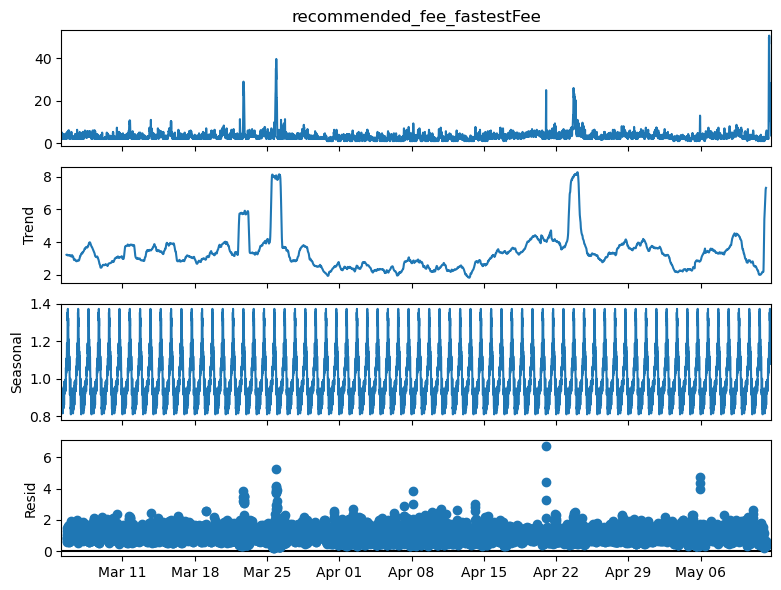

In [59]:
# Resample to 15-minute intervals
df_15min = df['recommended_fee_fastestFee'].resample('15min').mean().dropna()

# Perform seasonal decomposition (1-day = 96 intervals)
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_15min_day = seasonal_decompose(df_15min, model='multiplicative', period=96)

# Plot results
fig = decomp_15min_day.plot()
fig.set_size_inches(8, 6)
for ax in fig.axes:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

The decomposition of 15-minute resampled data with a daily periodicity (period = 96) reveals a clear and stable seasonal structure:

- The **seasonal component** shows consistent daily cycles with aligned peaks and troughs, confirming a strong 24-hour behavioral rhythm across the dataset.
- The **trend component** captures multi-day shifts and fee level changes, including pronounced spikes around late March and early May—previously identified as congestion periods.
- The **residual component** remains small and mostly noisy, except during these volatility spikes, indicating that most structure is captured by the seasonal and trend components.

These findings validate the use of a **daily seasonal period (s = 96)** in downstream modeling such as SARIMA, where incorporating this seasonality is expected to improve predictive accuracy and reduce residual variance.

#### 8.6 Weekly Seasonal Structure in 15-Minute Data

To investigate whether longer-term weekly cycles are present in the resampled data, we apply seasonal decomposition using a weekly periodicity of 672 (15-minute intervals × 7 days).

This analysis will help determine whether SARIMA models should include weekly seasonal components.

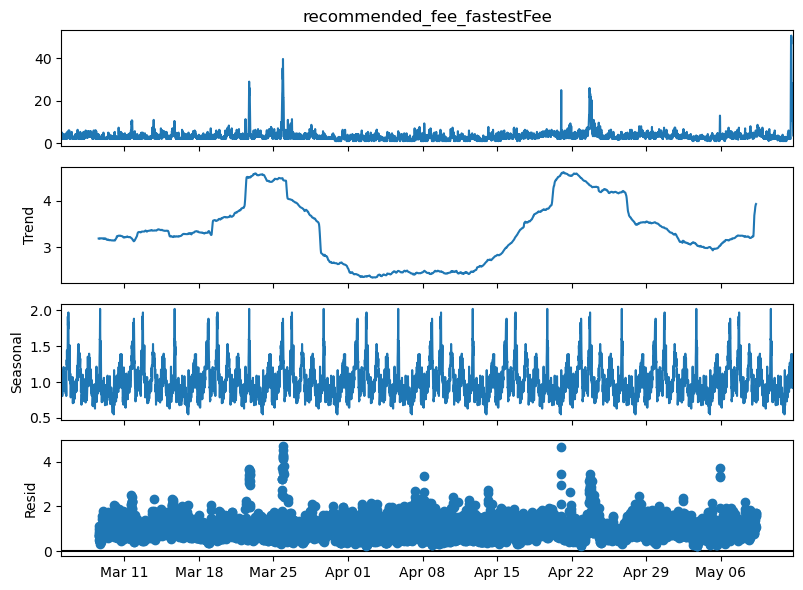

In [60]:
# Weekly periodicity: 15min × 672 = 1 week
decomp_15min_week = seasonal_decompose(df_15min, model='multiplicative', period=672)

# Plot and format x-axis
fig = decomp_15min_week.plot()
fig.set_size_inches(8, 6)

for ax in fig.axes:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

The seasonal decomposition with weekly periodicity (s = 672) does not reveal a consistent or clearly repeating weekly pattern.  
The seasonal component appears noisy and may be overshadowed by the stronger and more stable daily cycles observed earlier.

This suggests that a **weekly seasonal structure is not strongly supported** in the current data and is likely unnecessary for SARIMA or related models.

We will therefore proceed with **daily seasonality only (s = 96)** for downstream modeling.

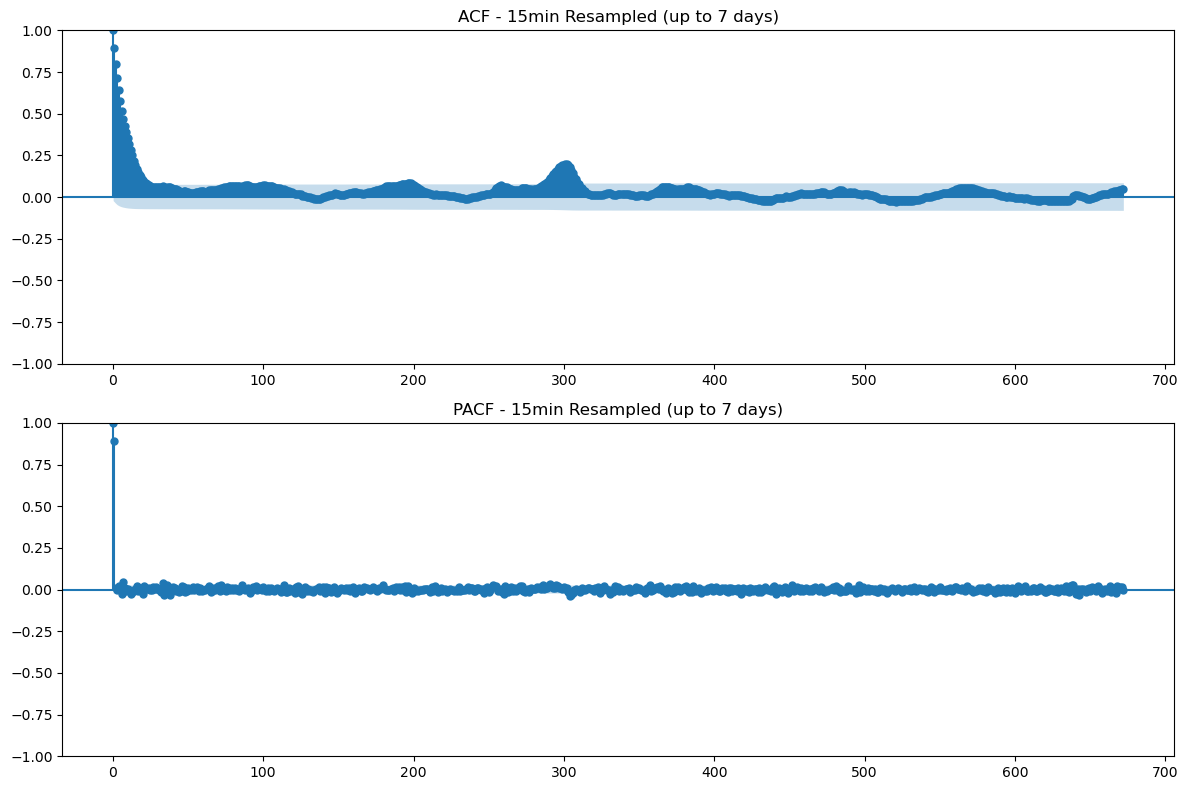

In [61]:
# Plot ACF & PACF for up to 672 lags (7 days)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_15min, lags=672, ax=ax[0], title="ACF - 15min Resampled (up to 7 days)")
plot_pacf(df_15min, lags=672, ax=ax[1], title="PACF - 15min Resampled (up to 7 days)")
plt.tight_layout()
plt.show()

To investigate whether the 15-minute resampled `fastestFee` series exhibits any weekly structure, we extended ACF and PACF plots to 672 lags (i.e., 7 days × 96 intervals).

**Observations:**
- The **ACF plot** shows strong and regular peaks every ~96 lags, confirming **clear daily seasonality** in the series.
- A small bump appears around lag 288–300, which may correspond to **partial weekend effects**, but it is weak and not consistently repeated.
- The **PACF plot** drops off sharply after lag 1, indicating **strong short-term autoregression** and minimal long-lag partial correlation.

**Conclusion:**
- The series exhibits **strong daily seasonality**, but **no robust weekly seasonality**.
- Models incorporating **daily seasonal components** (e.g., SARIMA with `seasonal_period=96`) are well-justified.
- Weekly effects may be too inconsistent to model explicitly but could be explored through external features if needed.

To further validate this, we extended the ACF plot up to 3360 lags (≈ 5 weeks). This confirmed that **no stable weekly autocorrelation structure persists**, reinforcing our decision to **exclude weekly seasonal terms** in downstream modeling.


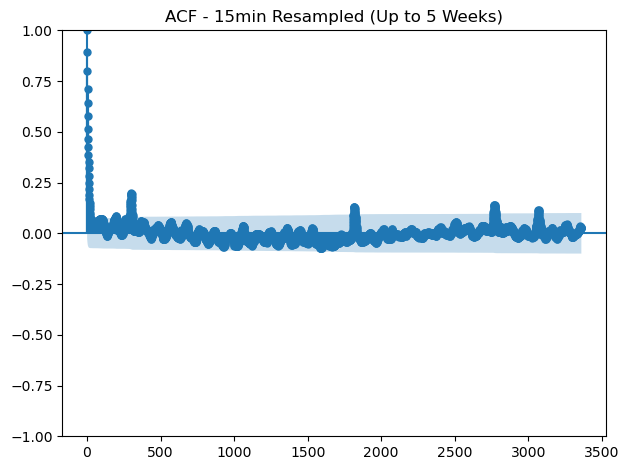

In [62]:
# Plot ACF up to 5 weeks (3360 lags at 15min intervals)
plot_acf(df_15min, lags=3360, title="ACF - 15min Resampled (Up to 5 Weeks)")
plt.tight_layout()
plt.show()

**Observations:**

- A strong daily pattern is again observed at lag ≈ 96 (i.e., 1 day), consistent with earlier findings.
- A minor secondary peak appears around lag ≈ 288–300, possibly reflecting intra-week behavior (e.g., weekend effect).
- Beyond that, **no consistent peaks** are observed at multiples of 672 (i.e., weekly lags).
- The ACF decays gradually and becomes noisy beyond ~500 lags, indicating limited long-term autocorrelation structure.

**Conclusion:**

- The series exhibits **strong daily seasonality**, but **no stable or repeating weekly seasonality** over the 5-week window.
- Therefore, we will **not include explicit weekly components** in SARIMA or other seasonal models.
- Our modeling will focus on **daily cycles only**, using `seasonal_period = 96` for 15-minute data to capture recurring daily patterns.


### 9. Correlation Heatmap

#### 9.1 Group-wise Feature Correlation Heatmaps
We visualize the correlation among feature groups using heatmaps.

In [63]:
group_prefixes = {
    # "mempool_blocks": "mempool_blocks_",
    "recommended_fee": "recommended_fee_",
    "mempool": "mempool_",
    "difficulty_adjustment": "difficulty_adjustment_",
    "price": "price_"
}
excluded_prefixes = ["mempool_fee_histogram_"]
def plot_group_correlation(df, group_name, prefix, exclude_prefixes=None):
    # Select columns matching prefix
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    
    # Exclude anything that starts with excluded prefixes
    if exclude_prefixes:
        group_cols = [col for col in group_cols if not any(col.startswith(ex) for ex in exclude_prefixes)]

    # Drop NA for correlation
    group_df = df[group_cols].dropna()

    # Skip if not enough features
    if len(group_cols) < 2:
        print(f"Skipping group '{group_name}' — fewer than 2 valid columns.")
        return

    # Compute correlation
    corr = group_df.corr()

    # Shorten columns that start with 'difficulty_adjustment_' to 'diff_adj_'
    corr.columns = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.columns]
    corr.index = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.index]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
    plt.title(f"{group_name} Feature Correlation")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


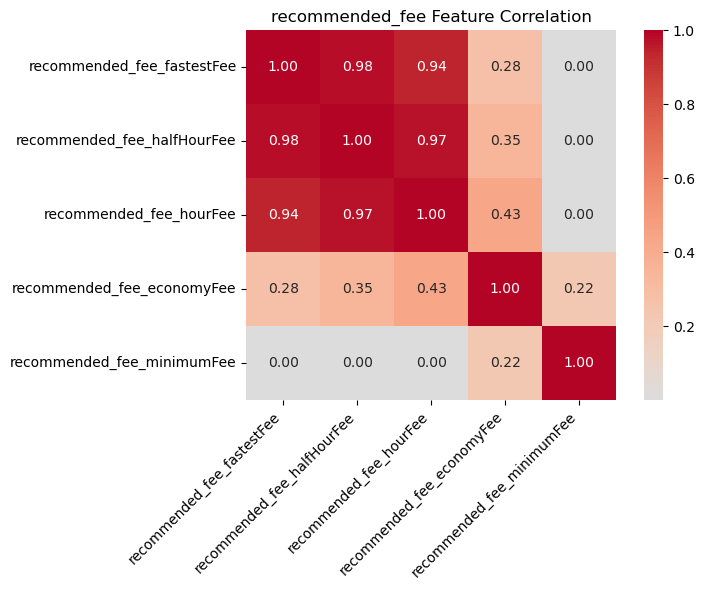

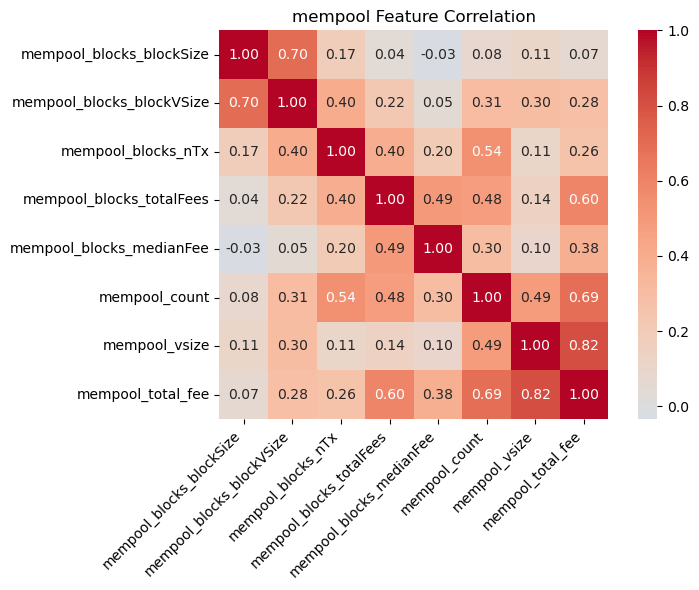

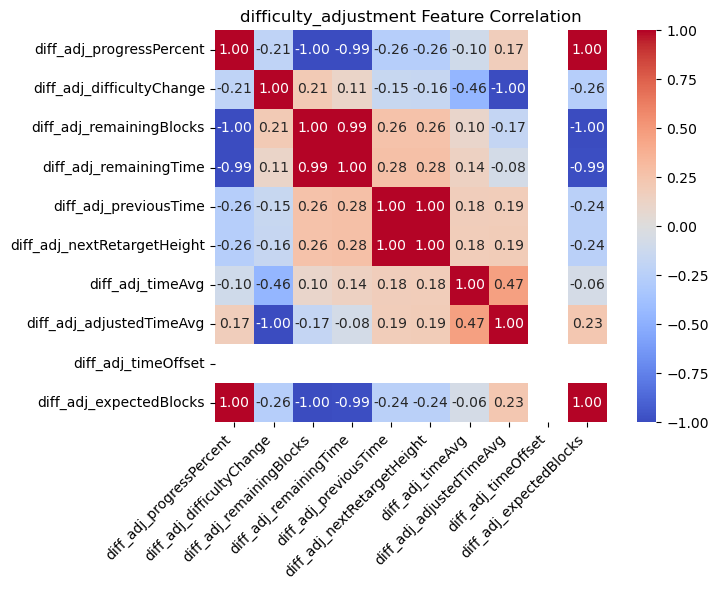

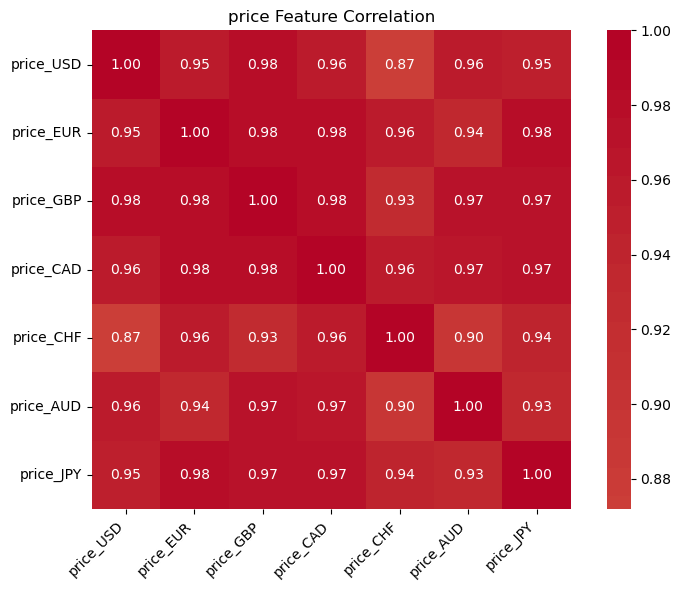

In [64]:
for group_name, prefix in group_prefixes.items():
    plot_group_correlation(df, group_name, prefix, exclude_prefixes = excluded_prefixes)


The correlation heatmaps reveal several key relationships across feature groups:

- **Recommended Fee Group**  
  `fastestFee`, `halfHourFee`, and `hourFee` are highly correlated (p > 0.9), suggesting they capture similar network conditions.  
  In contrast, `economyFee` and `minimumFee` show weaker or no correlation, indicating they may reflect different user behavior (e.g., low-priority transactions).

- **Mempool Group**  
  Features like `mempool_vsize` and `mempool_total_fee` are strongly correlated (p > 0.8), likely due to shared dependence on transaction volume.  
  However, `mempool_blocks_medianFee` is weakly correlated with most others, potentially offering unique information about block-level fee trends.

- **Difficulty Adjustment Group**  
  Many features show perfect positive or negative correlations (e.g., `remainingBlocks` vs. `progressPercent`, r = -1.0), reflecting deterministic relationships from Bitcoin’s difficulty adjustment algorithm.  
  This suggests redundancy within the group and motivates dimensionality reduction (e.g., dropping derived variables).

- **Price Group**  
  All fiat-denominated Bitcoin prices (USD, EUR, GBP, etc.) are highly correlated (p > 0.9), as expected given stable exchange rates.  
  These features are interchangeable unless currency-specific effects are being studied.

---

These insights help:

- Identify **feature redundancy** (e.g., exact/inverse correlations in difficulty features)
- **Select representative variables** for modeling (e.g., keep one of the high-correlation fee types)
- **Avoid multicollinearity** when applying linear models or interpreting coefficients


### 9.2 Correlation Analysis with Significance Testing

We compute both **Pearson** and **Spearman** correlation matrices for selected congestion-related features  
to examine their relationships with the target variable `recommended_fee_fastestFee`.

To assess the reliability of these correlations, we also include **p-value checks** to confirm statistical significance.  
This helps ensure that observed correlations are not due to random variation.


In [65]:
corr_features = [
    "recommended_fee_fastestFee",
    "mempool_total_fee",
    "mempool_count",
    "mempool_blocks_nTx",
    "mempool_blocks_blockVSize",
    "difficulty_adjustment_difficultyChange",
    "mempool_blocks_totalFees"
]

# Prepare correlation and p-value matrices
pearson_corr = pd.DataFrame(index=corr_features, columns=corr_features)
pearson_pval = pd.DataFrame(index=corr_features, columns=corr_features)

spearman_corr = pd.DataFrame(index=corr_features, columns=corr_features)
spearman_pval = pd.DataFrame(index=corr_features, columns=corr_features)

for i in corr_features:
    for j in corr_features:
        x = df[i].dropna()
        y = df[j].dropna()
        common_idx = x.index.intersection(y.index)
        if len(common_idx) > 2:
            # Pearson
            r, p = pearsonr(x[common_idx], y[common_idx])
            pearson_corr.loc[i, j] = r
            pearson_pval.loc[i, j] = p
            # Spearman
            r_s, p_s = spearmanr(x[common_idx], y[common_idx])
            spearman_corr.loc[i, j] = r_s
            spearman_pval.loc[i, j] = p_s

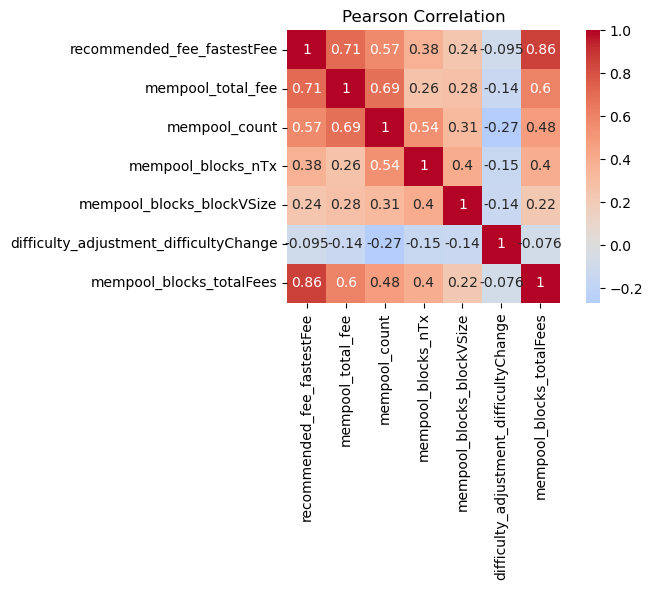

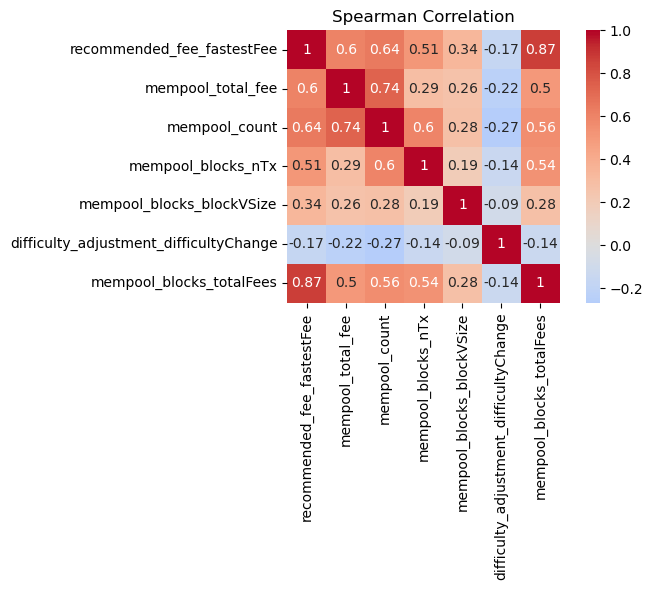

In [66]:
# Pearson correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr.astype(float), annot=True, cmap='coolwarm', center=0, square=True)
plt.title("Pearson Correlation")
plt.tight_layout()
plt.show()

# Spearman correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr.astype(float), annot=True, cmap='coolwarm', center=0, square=True)
plt.title("Spearman Correlation")
plt.tight_layout()
plt.show()

In [67]:
# Extract p-values and correlation against target
target = "recommended_fee_fastestFee"
corr_summary = pd.DataFrame({
    'Pearson_corr': pearson_corr.loc[target],
    'Pearson_p': pearson_pval.loc[target],
    'Spearman_corr': spearman_corr.loc[target],
    'Spearman_p': spearman_pval.loc[target]
})

# Define formatter for p-values
def format_pval(p):
    if pd.isnull(p):
        return "NA"
    elif p < 0.0001:
        return "<0.0001"
    else:
        return f"{p:.4f}"

# Apply formatting
corr_summary_formatted = corr_summary.copy()
corr_summary_formatted["Pearson_corr"] = corr_summary_formatted["Pearson_corr"].round(2)
corr_summary_formatted["Spearman_corr"] = corr_summary_formatted["Spearman_corr"].round(2)
corr_summary_formatted["Pearson_p"] = corr_summary_formatted["Pearson_p"].apply(format_pval)
corr_summary_formatted["Spearman_p"] = corr_summary_formatted["Spearman_p"].apply(format_pval)

# Display result
display(corr_summary_formatted)

,Pearson_corr,Pearson_p,Spearman_corr,Spearman_p
recommended_fee_fastestFee,1.0,<0.0001,1.0,<0.0001
mempool_total_fee,0.707316,<0.0001,0.599368,<0.0001
mempool_count,0.574103,<0.0001,0.644178,<0.0001
mempool_blocks_nTx,0.375526,<0.0001,0.509862,<0.0001
mempool_blocks_blockVSize,0.237063,<0.0001,0.337162,<0.0001
difficulty_adjustment_difficultyChange,-0.094723,<0.0001,-0.165411,<0.0001
mempool_blocks_totalFees,0.857871,<0.0001,0.868462,<0.0001


#### Interpretation

Both Pearson and Spearman correlation analyses reveal statistically significant relationships between `recommended_fee_fastestFee` and several congestion-related features.

**Key Findings:**

- **`mempool_blocks_totalFees`** shows the **strongest correlation** with the target, with r = 0.86 (Spearman) and r = 0.86 (Pearson), indicating it's a highly predictive variable.
- **`mempool_total_fee`**, **`mempool_count`**, and **`mempool_blocks_nTx`** also exhibit moderate-to-strong positive correlations (r = 0.5–0.7), reflecting their direct ties to network congestion.
- **`difficulty_adjustment_difficultyChange`** shows **low or negative correlation** and comparatively higher p-values (e.g., 0.024 in Pearson), suggesting its relationship with the target is weak or potentially non-causal.

All other features show **p-values < 0.0001**, confirming that observed correlations are statistically significant and unlikely to result from chance.

This dual-method approach (Pearson for linear, Spearman for monotonic trends) confirms both the **magnitude** and **directional consistency** of relationships, strengthening confidence in using these variables for downstream modeling and feature selection.


### 10. Key features

#### 10.1 Summary Table of Selected Features

Since our goal is to forecast fee rates, the key features should be those that are:

1. Directly Related to Fee Behavior
Influence how fees are set or how congestion builds up
Reflect network load or transaction priority dynamics
2. Useful for Forecasting Time Series
Time-varying
Available in real-time or known into the future

| Category                | Features                                                                                      | Why Important?                                                                                      |
|-------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| Target & Fee Estimates  | `recommended_fee_fastestFee`, `recommended_fee_halfHourFee`, `recommended_fee_hourFee`, `recommended_fee_economyFee`, `recommended_fee_minimumFee` | These are the predicted targets (or close variants), and how the mempool system estimates current rates |
| Mempool Congestion      | `mempool_count`, `mempool_vsize`, `mempool_total_fee`                                        | Reflect the real-time network load and pending demand                                              |
| Block Characteristics   | `mempool_blocks_blockSize`, `mempool_blocks_blockVSize`, `mempool_blocks_nTx`, `mempool_blocks_totalFees`, `mempool_blocks_medianFee` | Describe current mining block shape and behavior                                                  |
| Difficulty Signals      | `difficulty_adjustment_remainingBlocks`, `difficulty_adjustment_difficultyChange`, `difficulty_adjustment_adjustedTimeAvg` | Affect block production pace and expected fee demand                                              |
| Market Prices           | `price_USD`, `price_CAD`, `price_EUR`, etc.                                                   | May capture global market sentiment and volume, though likely weak correlates unless fees are fiat-tied |



#### 10.2 Distributions of Selected Features

We visualize the distribution of selected key features to assess skewness, potential outliers, and feature variability. This helps determine if any transformation (e.g., log) may be beneficial before modeling.

In [68]:
key_features = [
    # fee estimates
    "recommended_fee_fastestFee",
    "recommended_fee_halfHourFee",
    "recommended_fee_hourFee",
    "recommended_fee_economyFee",
    "recommended_fee_minimumFee",
    
    # mempool state
    "mempool_count",
    "mempool_vsize",
    "mempool_total_fee",
    
    # block metrics
    "mempool_blocks_blockSize",
    "mempool_blocks_blockVSize",
    "mempool_blocks_nTx",
    "mempool_blocks_totalFees",
    "mempool_blocks_medianFee",
    
    # difficulty signals (select most relevant)
    "difficulty_adjustment_remainingBlocks",
    "difficulty_adjustment_difficultyChange",
    "difficulty_adjustment_adjustedTimeAvg",
    
    # market signal 
    "price_USD"
]


In [69]:
def plot_distributions(columns, cols_per_row=3):
    rows = int(np.ceil(len(columns) / cols_per_row))
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color="cornflowerblue")
        axes[i].set_title(col, fontsize=11)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Key Feature Distributions (excluding histogram bins)", fontsize=16)
    fig.tight_layout()
    plt.show()

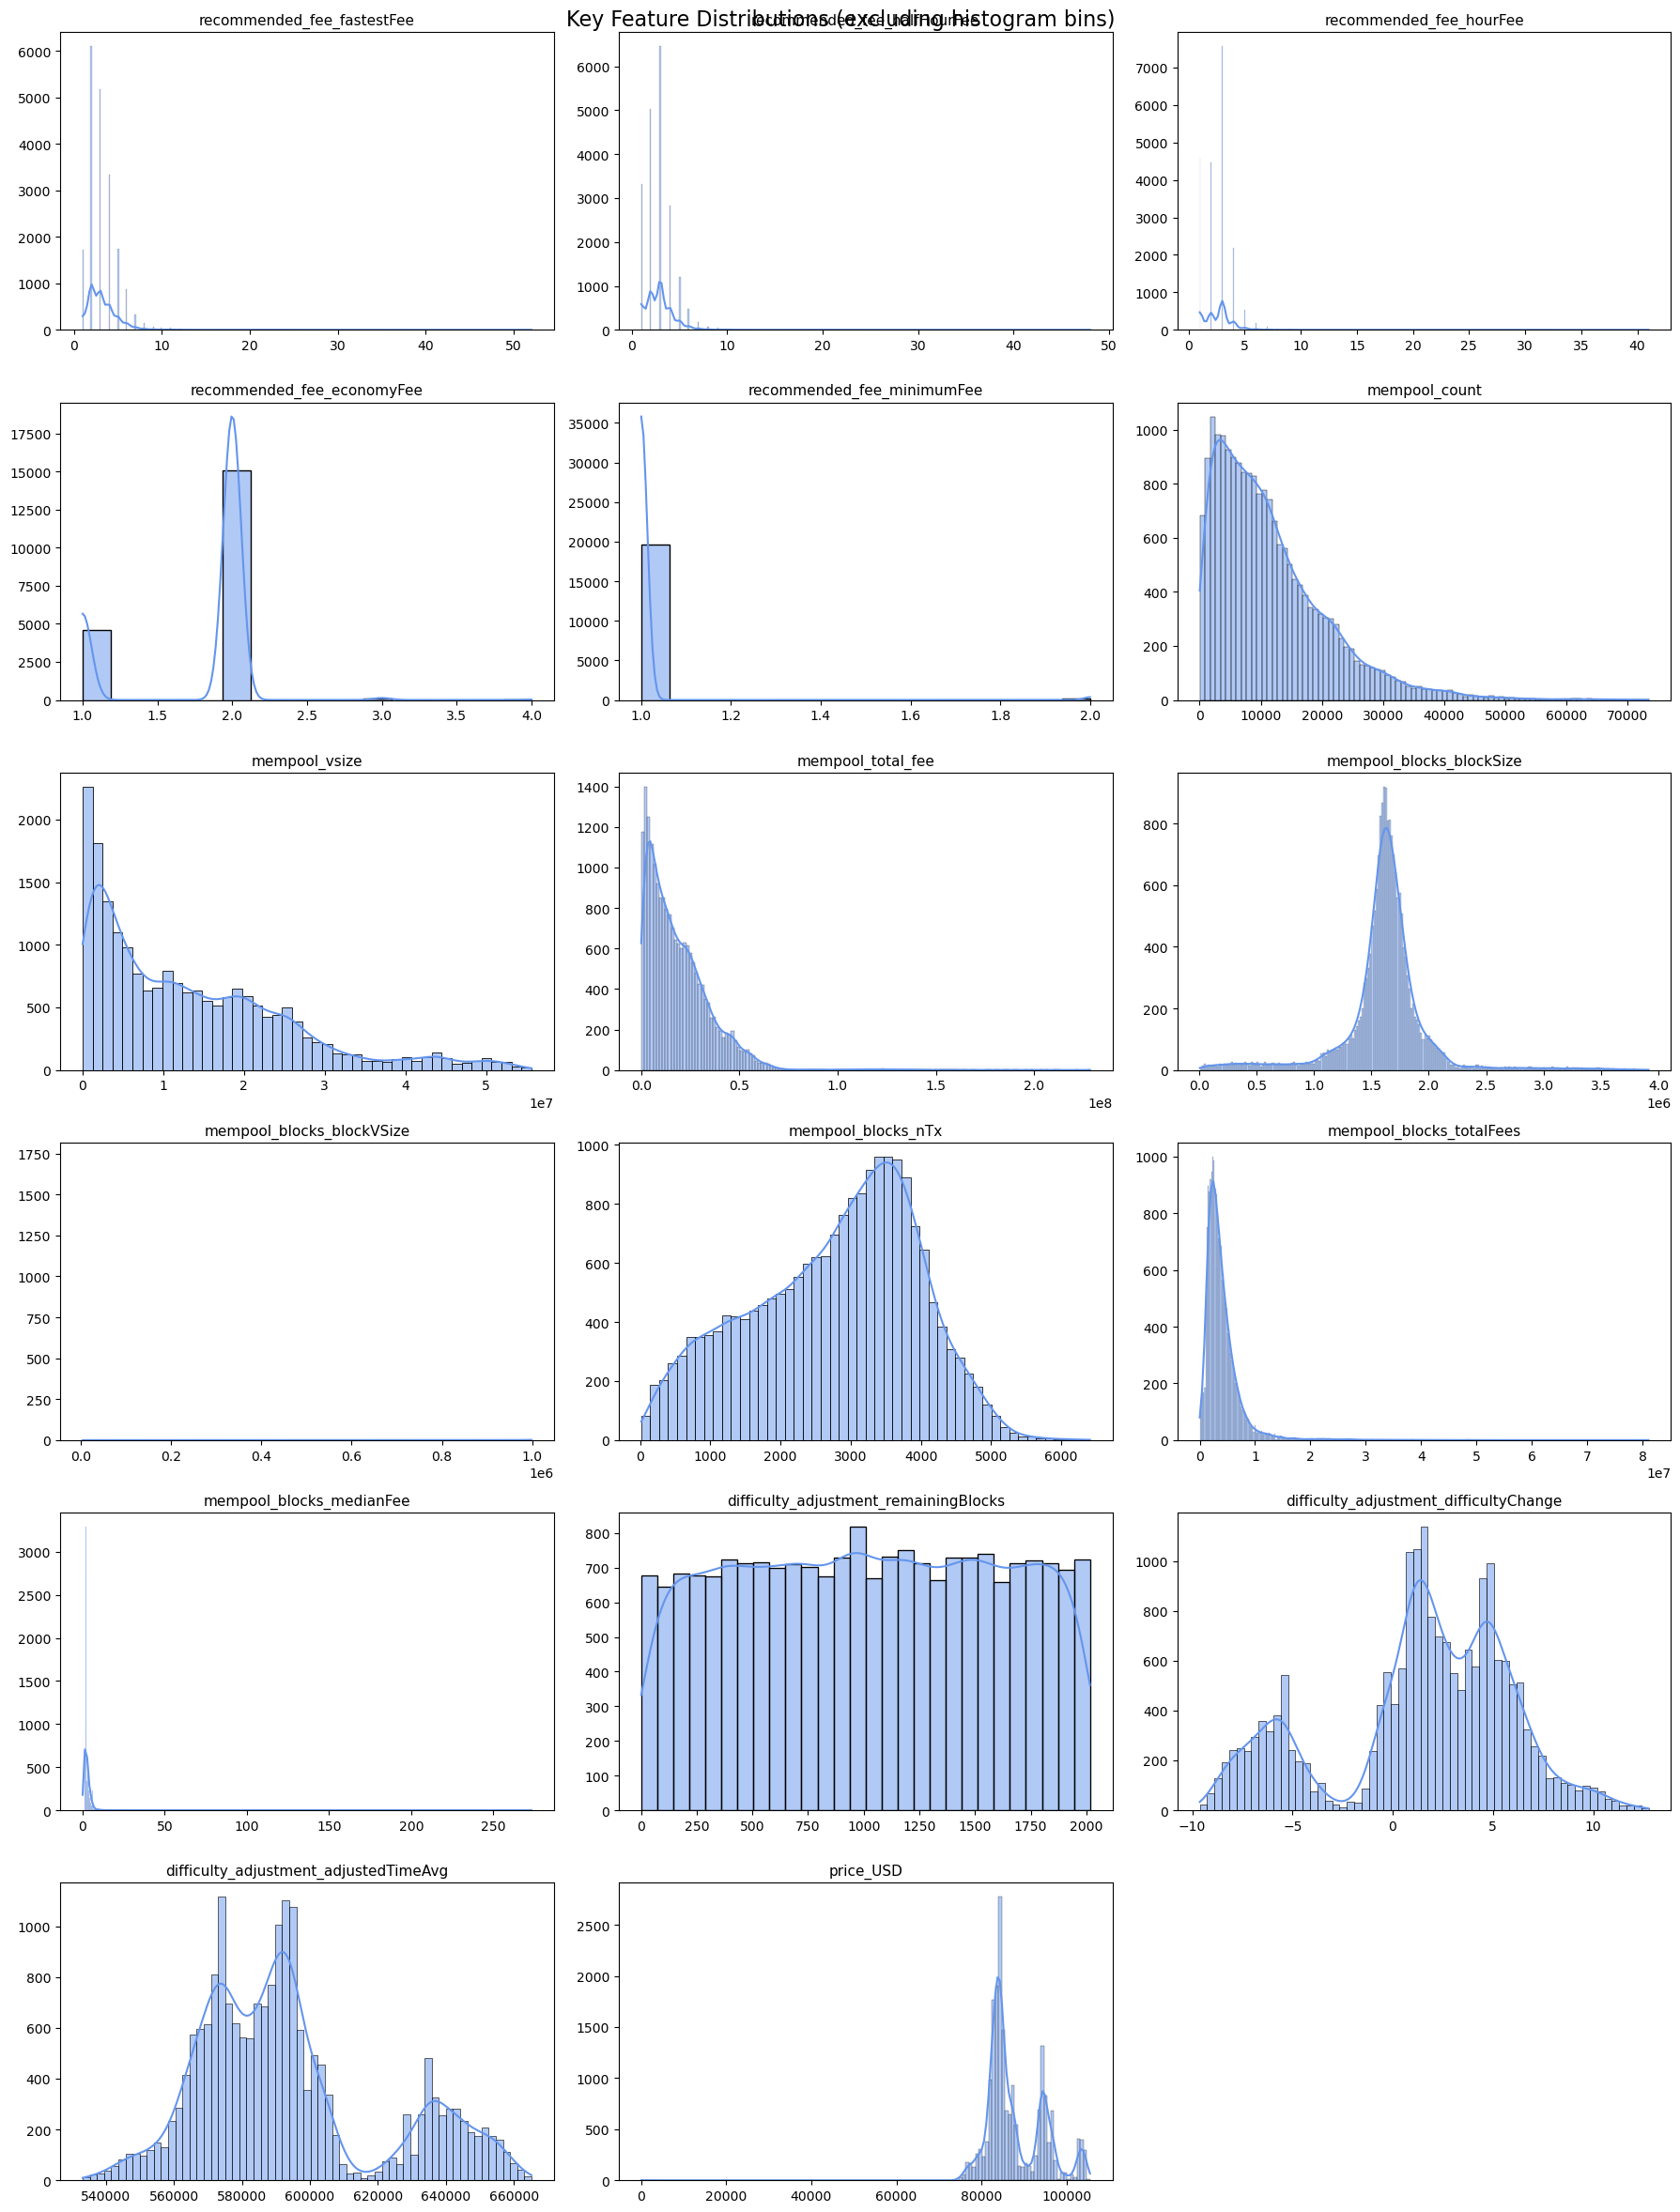

In [70]:
plot_distributions(key_features)


This section identifies the most relevant features for forecasting transaction fee rates. These include direct fee estimates, mempool congestion indicators, mining block characteristics, difficulty adjustment signals, and market prices.
The visual inspection shows that many of these features are highly skewed (e.g., `recommended_fee_fastestFee`, `mempool_total_fee`), suggesting the potential need for transformation (e.g., log-scaling) in modeling.
This curated set of features will guide the baseline and advanced forecasting models in subsequent stages.

### 11. Modeling Strategy Informed by EDA

We summarize EDA insights to justify modeling choices and guide the overall forecasting strategy.

---

#### Key Observations from EDA

- **Stationarity:**  
  ADF tests confirm that the target variable `fastestFee` is stationary. Differencing is not needed for ARIMA-family models.

- **Seasonality:**  
  Strong daily seasonality is evident after 15-minute resampling (96 intervals per day).  
  Weekly seasonality was tested but found to be weak and inconsistent.

- **Volatility:**  
  The target exhibits congestion-driven spikes and sharp variability, making it challenging for linear models to fully capture.

- **Correlations:**  
  Features like `mempool_total_fee`, `mempool_blocks_totalFees`, and `mempool_count` are highly correlated with the target, offering strong predictive signals.

- **Multivariate Signals:**  
  The dataset includes a diverse set of features across mempool state, block metrics, difficulty adjustment, and market price—supporting multivariate time series modeling.

---

#### Model Strategy

Based on these findings, we adopt a two-stage modeling strategy to balance interpretability, robustness, and forecasting performance.

##### 1. Baseline Models
- **SARIMA (Seasonal ARIMA):**  
  Leverages autocorrelation and seasonality in a univariate setting (with `seasonal_period = 96`).
- **HWES (Holt-Winters Exponential Smoothing):**  
  Captures level and seasonal patterns with minimal tuning; suitable for short-term seasonal forecasting.
- **XGBoost:**  
  A tree-based model capable of handling nonlinearity, lagged inputs, and multivariate dependencies.

##### 2. Advanced Models
- **Prophet:**  
  Decompositional model that handles missing data and strong seasonality well; interpretable and scalable.
- **DeepAR:**  
  Recurrent neural network designed for sequential probabilistic forecasting on time series data.
- **Temporal Fusion Transformer (TFT):**  
  A state-of-the-art attention-based model that captures temporal dependencies and interactions across multiple features with built-in interpretability.

---

This strategy allows us to:
- Benchmark traditional time series models against machine learning and deep learning alternatives;
- Assess the effect of incorporating exogenous variables and seasonal terms;
- Progressively move toward a performant and interpretable forecasting pipeline.

---

### EDA Summary

#### 1. Distributional Analysis
- `fastestFee` is highly skewed and volatile, with spikes during congestion periods.
- Fee bin counts were log-transformed to reduce skewness and stabilize variance.
- Several features (e.g., `mempool_count`, `price_usd_diff_1h`, `block_interval`) exhibit long-tailed distributions, suggesting potential benefit from normalization.

#### 2. Seasonality and Trend
- Seasonal decomposition reveals strong and consistent daily cycles.
- Weekly patterns (672 intervals) were tested but showed no stable or repeating structure.
- Both additive and multiplicative decompositions support inclusion of seasonal components in modeling.

#### 3. Stationarity Checks
- ADF test confirms stationarity of the target (p < 0.01); no differencing is required.
- Rolling mean and standard deviation are relatively stable.
- ACF and PACF plots suggest AR(2)-like structure.

#### 4. Modeling Preparation
- Key features selected across four domains: fee estimates, mempool metrics, block-level stats, and market prices.
- Lag features are motivated by autocorrelation patterns.
- The dataset supports both univariate models (SARIMA, HWES) and multivariate models (XGBoost, DeepAR, TFT).
